# Plotting Fig 2

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn import metrics
from scipy import stats

import warnings
import matplotlib as mpl
import plot_utils

warnings.filterwarnings('ignore', 'invalid value encountered in true_divide')

## Settings

In [2]:
TEXTWIDTH = 6.7261  # in
DPI = 360
fliersize = 3

In [3]:
def set_font_size(font_size):
    plt.rc('font', size=font_size)          # controls default text sizes
    plt.rc('axes', titlesize=font_size)     # fontsize of the axes title
    plt.rc('axes', labelsize=font_size)     # fontsize of the x and y labels
    plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=font_size, title_fontsize=font_size)    # legend fontsize
    plt.rc('figure', titlesize=font_size)   # fontsize of the figure title

In [4]:
sb.set(context='paper', style='whitegrid')
plt.rc('grid', linewidth=0.3)
sb.set_palette('colorblind')
set_font_size(6)

In [5]:
palette_tcrs = {'OTI': 'tab:green',
                'Educated': 'tab:orange',
                'Naive': 'tab:blue',  
                'OT-I': 'tab:green', 
                'Naïve': 'tab:blue',
                'Human': 'Firebrick'
               }
palette_tcrs_cmap = [palette_tcrs['OTI'], palette_tcrs['Educated'], palette_tcrs['Naive']]

cmap_positions = mpl.colors.ListedColormap(['silver'] + sb.color_palette('Purples', 12)[3:])

cmap_heatmap = 'rocket'

color_base ='silver'
color_thresh = 'silver'
color_random = 'silver'
style_base = ':'
style_thresh = '--'

In [6]:
def tcr_2_color(tcr, color=True):
    if tcr.startswith('R'):
        return palette_tcrs['Human'] if color else 3
    if tcr == 'OTI':
        return palette_tcrs['OTI'] if color else 0
    if tcr.startswith('Ed'):
        return palette_tcrs['Educated'] if color else 1
    return palette_tcrs['Naive'] if color else 2

## Load Data

In [7]:
def read_mice_subset(is_educated, normalization='AS'):
    if is_educated:
        path_in = '../data/Affinity_prediction_educated_repertoire.xlsx'
    else:
        path_in = '../data/Affinity_prediction_naive_repertoire.xlsx'
    if normalization == 'AS':
        df = pd.read_excel(path_in, 'Normalized data', skiprows=1)
    else:
        df = pd.read_excel(path_in, 'Individual APL screening', skiprows=1)
    #columns = df.columns
    #tcrs = columns[::4]
    #columns = columns[3::4]
    df = df[[el for el in df.columns if not el.startswith('Unnamed')]]
    
    df_pos = pd.read_excel(path_in, 'Individual APL screening', skiprows=1)
    df_pos.loc[152, 'Position'] = 0
    df['Mutated_position'] = df_pos['Position']
    df = df.drop(columns=['Sequence', 'Amino Acid', 'Position', 'APL'], errors='ignore')
    return df

In [8]:
def read_mice_data(normalization='AS'):
    data_naive = read_mice_subset(False, normalization=normalization)
    data_educated = read_mice_subset(True, normalization=normalization)
    
    data_joint = pd.concat([data_naive, data_educated], axis=1, join='inner')
    order = list(data_joint.columns)
    order.remove('OTI')
    order = ['OTI'] + [x for x in order if x.startswith('Ed')] + [x for x in order if not x.startswith('Ed')]
    data_joint = data_joint[order]
    data_joint.index = [f'{i//19 + 1}_{i%19}' for i in range(len(data_joint))]
    data_joint = data_joint.rename(index={'9_0': '0_0'})
    
    data_joint = data_joint[[col for col in data_joint.columns if col != 'Mutated_position']]
    return data_joint

In [9]:
data_mice_norm = read_mice_data(normalization='AS')
data_mice_unnorm = read_mice_data(normalization='None')

## Within Repertoire Prediction

In [10]:
def compute_metrics(g):
    return pd.Series({
        'MAE': g['abserr'].mean(),
        'R2': metrics.r2_score(g['act'], g['pred']),
        'Pearson': g['act'].corr(g['pred'], method='pearson'),
        'Spearman': g['act'].corr(g['pred'], method='spearman'),
        'AUC': (
            metrics.roc_auc_score(g['is_activated'], g['pred_prob'])
            if np.isfinite(g['pred_prob']).all() and 0 < g['is_activated'].mean() < 1
            else np.nan
        ),
        'APS': (
            metrics.average_precision_score(g['is_activated'], g['pred_prob'])
            if np.isfinite(g['pred_prob']).all()
            else np.nan
        ),
        'Spearman_class': g['act'].corr(g['pred_prob'], method='spearman'),
    })

In [11]:
def assign_repertoire(tcr):
    tcr = tcr.upper()
    if tcr == 'OTI':
        return 'OTI'
    if tcr.startswith('ED'):
        return 'Educated'
    if tcr.startswith('R'):
        return 'Human'
    return 'Naive'

In [12]:
def load_perf_data():        
    path_in = '../activation-prediction/results'
    ppdf = pd.read_csv(f'{path_in}/SIINFEKL_tcr_specific_data_size.csv.gz')    
    ppdf = ppdf[ppdf['normalization'] == 'AS']

    # compute metric for each validation fold separately
    mdf = pd.concat([
        # except for lmo CV where each validation fold contained a single sample
        # in that case we just compute a global average for each tcr
        ppdf.query('features=="lmo"') \
            .groupby(['features', 'tcr']) \
            .apply(compute_metrics).reset_index(),
        ppdf.query('features!="lmo"') \
            .groupby(['features', 'tcr', 'fold']) \
            .apply(compute_metrics).reset_index(),
    ])

    mdf['features'] = mdf['features'].str.upper()

    lmdf = mdf.melt(
        id_vars=['tcr', 'features', 'fold'],
        value_vars=['R2', 'Pearson', 'Spearman','Spearman_class', 'MAE', 'APS', 'AUC'],
        var_name='Metric'
    ).rename(
        columns={'features': 'Split', 'value': 'Value'}
    )
    
    lmdf['Repertoire'] = lmdf['tcr'].apply(assign_repertoire)
    ppdf['Repertoire'] = ppdf['tcr'].apply(assign_repertoire)

    return ppdf, lmdf
ppdf, lmdf = load_perf_data()

C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\felix.drost\Ana

## Plotting data

In [13]:
def plot_activation_heatmap(data, gs_full, fig, yscale=1):
    data = data.transpose()       
    gs_12 = mpl.gridspec.GridSpecFromSubplotSpec(subplot_spec=gs_full,
                                              nrows=2, ncols=1, 
                                              height_ratios=[0.03*yscale+1, 0.05*yscale],
                                              hspace=0.05*yscale)
    
    gs = mpl.gridspec.GridSpecFromSubplotSpec(subplot_spec=gs_12[0],
                                              nrows=2, ncols=2, 
                                              width_ratios=[0.03, 1], height_ratios=[0.03*yscale, 1],
                                              wspace=0.01, hspace=0.01*yscale)
    
    cbar_width = 0.75
    gs_3 = mpl.gridspec.GridSpecFromSubplotSpec(subplot_spec=gs_12[1],
                                              nrows=1, ncols=4, 
                                              width_ratios=[0.03, (1-cbar_width)/2, cbar_width, (1-cbar_width)/2],
                                              wspace=0.01)

    # tcr color code
    ax_rowcolors = fig.add_subplot(gs[2])
    tcr_colors = np.array([tcr_2_color(tcr, color=False) for tcr in data.index]).reshape((-1, 1))

    tcrs_selected = ['ED21', 'ED28', 'ED39', 'B11', 'G6', 'E8', 'ED8', 'ED5', 'F5', 'H5', 'E9']
    yticklabels = [el.upper() if (el[0]=='R') or (el.upper() in tcrs_selected) else '' for el in data.index]
    
    sb.heatmap(tcr_colors, ax=ax_rowcolors, cbar=False, cmap=palette_tcrs_cmap, yticklabels=yticklabels, xticklabels=False,
              vmin=0, vmax=3)
    ax_rowcolors.set_ylabel('TCR', labelpad=0)
    ax_rowcolors.tick_params(axis='y', length=0, pad=1, labelsize='x-small')

    # apl annotation
    ax_colcolors = fig.add_subplot(gs[1])
    apl_colors = np.array([int(apl.split('_')[0]) for apl in data.columns]).reshape((1, -1))
    
    apl_labels = [''] * len(data.columns)
    idx_start = 0
    for i in list(set(apl_colors.tolist()[0]))[1:] + [0]:
        n_elements = np.sum(apl_colors==i)
        apl_labels[idx_start + n_elements//2] = f'P{i}' if i != 0 else ''
        idx_start += n_elements

    sb.heatmap(apl_colors, ax=ax_colcolors, cbar=False, yticklabels=False,
              vmin=0, vmax=9, cmap=cmap_positions, xticklabels=apl_labels,
              )
    ax_colcolors.set_xticklabels(apl_labels, rotation=0)
    ax_colcolors.xaxis.tick_top()
    ax_colcolors.tick_params(axis='x', length=0, pad=0)
    ax_colcolors.set_title('APLs', pad=3)

    # heatmap
    ax_main = fig.add_subplot(gs[3])
    ax_cbar = fig.add_subplot(gs_3[2])
    plot = sb.heatmap(data, ax=ax_main, cbar_ax=ax_cbar, cmap=cmap_heatmap,
                      cbar_kws={'label': 'Activation score (%)', "orientation": "horizontal", 'pad': 0.1})

    plot.set_yticks([])
    plot.set_xticks([])

    ax_main.grid(False)
    sb.despine(ax=ax_main, top=True, right=True, left=True, bottom=True)


In [14]:
def plot_tcrs_averaged(data_long, gs_full, xlabel='Activation Score (%)', yscale=1., fig=None):
    gs_12 = mpl.gridspec.GridSpecFromSubplotSpec(subplot_spec=gs_full,
                                          nrows=2, ncols=1, 
                                          height_ratios=[0.03*yscale+1, 0.05*yscale],
                                          hspace=0.05*yscale)
    gs = mpl.gridspec.GridSpecFromSubplotSpec(subplot_spec=gs_12[0],
                                          nrows=2, ncols=1,
                                          height_ratios=[0.03*yscale, 1],
                                          hspace=0.01*yscale)
    ax = fig.add_subplot(gs[1])
    
    data = data_long.copy()
    data = data.melt(ignore_index=False)
    data = data.reset_index()
    data = data.rename(columns={'variable': 'TCR', 'value': 'Activation', 'index': 'Epitope'})

    data['cat'] = 'Naive'
    data.loc[data['TCR'] == 'OTI', 'cat'] = 'OTI'
    data.loc[data['TCR'].str.startswith('Ed'), 'cat'] = 'Educated'
    data.loc[data['TCR'].str.startswith('R'), 'cat'] = 'Human'

    plot = sb.barplot(data=data, x='Activation', y='TCR', hue='cat', palette=palette_tcrs,
                       dodge=False, errwidth=0.5, ci='sd', orient='h', capsize=0.45,
                       ax=ax)

    ax.set_xlim(left=0)
    ax.set_yticklabels([])
    plot.set_xlabel(xlabel, labelpad=2)
    plot.tick_params(axis='both', length=0, pad=3)
    plot.set_ylabel('TCR', labelpad=2)
    plot.get_legend().remove()  
    ax.grid(False)
    sb.despine(ax=ax)
    return ax

In [15]:
def plot_epitopes(data, ax, ylabel='Activation Score (%)', base_epitope='SIINFEKL', threshold=46.9, do_legend=False):
    columns = [x for x in data.columns if x.startswith('Ed') or x.startswith('R')]
    data = data[columns]
    data['Activation'] = np.mean(data.values, axis=1)
    data = data[['Activation']]
    data['Mutated position'] = data.index.str.split('_').str[0].astype(int)

    activation_base = data.iloc[-1]['Activation']
    data = data[:-1]
    
    mut_pos = (data['Mutated position'].astype(int)).unique()
    palette = [cmap_positions.colors[p] for p in mut_pos] 
    
    plot = sb.swarmplot(data=data, y='Activation', x='Mutated position', s=2, 
                         hue='Mutated position', palette=palette, dodge=False, ax=ax)
    plot.set_ylabel(ylabel, labelpad=2)
    plot.set_xlabel(plot.get_xlabel(), labelpad=2)
    plot.set_xticklabels([f'P{el.get_text()}' for el in plot.get_xticklabels()])
    line_base = plot.axhline(activation_base, color=color_base, linestyle=style_base)
    if threshold:
        line_thresh = plot.axhline(threshold, color=color_thresh, linestyle=style_thresh)

    if not do_legend:
        plot.get_legend().remove()
    else:
        handles = [line_base, line_thresh] if threshold else [line_base]
        names =  ['Wild-type', 'Threshold'] if threshold else ['Wild-type']
        plot.legend(handles, names, ncol=2,
                    bbox_to_anchor=(0.5, 1.1), loc='upper center', frameon=True)
  
    ax.grid(False)
    sb.despine(ax=ax)
    ax.tick_params(axis='both', length=0, pad=3)

In [16]:
def plot_tcr_legend(label_ax, plotting_ax, style='center'):
    handles = []
    labels = []
    for ax in label_ax:
        h, l = ax.get_legend_handles_labels()
        handles += h
        labels += l
    
    for i, el in enumerate(labels):
        if el == 'Naive':
            labels[i] = 'Naïve'
        if el == 'OTI':
            labels[i] = 'OT-I'
    
    if style == 'center':
        plotting_ax.legend(handles=handles[:], labels=labels[:], ncol=1, title='Repertoire',
                           bbox_to_anchor=(0.25, 0.65), loc='center', frameon=True)
    elif style == 'center_right':
        plotting_ax.legend(handles=handles[:], labels=labels[:], ncol=1, title='Repertoire',
                           bbox_to_anchor=(0.45, 0.65), loc='center', frameon=True)
    elif style == 'top':
        plotting_ax.legend(handles=handles[:], labels=labels[:], ncol=4,
                           bbox_to_anchor=(-0.5, 1.25), loc='upper right', frameon=True)

## Plotting Within Repertoire

In [17]:
def plot_auc(data, ax, ylabel=None, xlabel=None, metric_func=metrics.roc_curve, metric_name='AUC'):
    if metric_func == metrics.roc_curve:
        ax.plot([0, 1], [0, 1], c=color_random, linestyle='--')
    
    groups = data.query('features == "lmo"').groupby('tcr')
    for i, (tcr, g) in enumerate(groups):
        x, y, _ = metric_func(g['is_activated'], g['pred'])
        kwargs = {
            'c': palette_tcrs[g['Repertoire'].values[0]],
            'alpha': 0.3 if tcr != 'OTI' else 1.0,
            'label': 'OTI' if tcr == 'OTI' else 'Educated' if 'ED' in tcr else 'Naive',
            'linewidth': 0.5
        }
        if metric_func == metrics.roc_curve:
            ax.plot(x, y, **kwargs)
        else:
            ax.plot(y, x, **kwargs)

    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.grid(False)
    if ylabel:
        ax.set_ylabel(ylabel, labelpad=0)
    else:
        ax.set_yticklabels([])
    if xlabel:
        ax.set_xlabel(xlabel, labelpad=0)
    else:
        ax.set_xticklabels([])
        
    ax.tick_params(axis='both', length=0, pad=3)
    
    df_mean = lmdf[lmdf['tcr'].isin(data['tcr'])]
    df_mean = df_mean[df_mean['Split']=='LMO']
    mean = df_mean[df_mean['Metric']==metric_name]['Value'].mean()
    ax.set_title(f'Avg {metric_name}: {mean:.3f}', pad=-2, size='medium')
    
    sb.despine(ax=ax)

In [18]:
order_metrics = ['AUC', 'APS', 'Spearman']
def plot_metric_boxplot(metrics, ax):        
    bp_data = lmdf.query('Split == "LMO"')
    bp_data = bp_data[bp_data['Metric'].isin(metrics)]
    
    bp_data['Repertoire'] = bp_data['Repertoire'].replace('Naive', 'Naïve')
    bp_data['Repertoire'] = bp_data['Repertoire'].replace('OTI', 'OT-I')
    sb.boxplot(
        data=bp_data,
        y='Value', hue='Repertoire', ax=ax,
        x='Metric', order=order_metrics,
        hue_order=['OT-I', 'Educated', 'Naïve'], palette=palette_tcrs,
        fliersize=fliersize,
        #color='#ffffffff'
    )
    
    ax.set_ylabel('Metric Score', labelpad=2)
    ax.set_xlabel('', labelpad=0)
    ax.legend().remove()
    ax.grid(False)
    sb.despine(ax=ax)
    
    ax.tick_params(axis='both', length=0, pad=3)

In [19]:
def plot_feature_tests(ax, metric='Spearman', do_legend=False):
    data_feats = lmdf.query(f'Metric=="{metric}"').groupby([
        'Repertoire', 'Split', 'tcr'
    ])['Value'].agg('mean').reset_index()

    data_feats = data_feats[data_feats['Split'].isin(['LMO', 'LPO', 'LAO'])]
    
    data_feats['Repertoire'] = data_feats['Repertoire'].replace('Naive', 'Naïve')
    data_feats['Repertoire'] = data_feats['Repertoire'].replace('OTI', 'OT-I')

    plot = sb.boxplot(data=data_feats, x='Split', y='Value', hue='Repertoire', palette=palette_tcrs, ax=ax,
                     hue_order=['OT-I', 'Educated', 'Naïve'], fliersize=fliersize,
                     order=['LMO', 'LPO', 'LAO'])
    
    ax.set_xlabel('', labelpad=0)
    ax.set_ylabel(metric, labelpad=2)
    
    if not do_legend:
        ax.legend().remove()
    else:
        ax.legend(bbox_to_anchor=(0., 1.25), loc="upper center", ncol=4, frameon=True)
    ax.grid(False)
    sb.despine(ax=ax)
    ax.tick_params(axis='both', length=0, pad=3)

In [20]:
def plot_data_size(ax, metric='Spearman'):
    data_size = lmdf.query(f'Metric=="{metric}"').groupby([
        'Repertoire', 'Split', 'tcr'
    ])['Value'].agg('mean').reset_index()

    data_size = data_size[~data_size['Split'].isin(['LMO', 'LPO', 'LAO'])]
    data_size = data_size.replace({'Split': {
        f'L{p}O': f'{100 - p}%' for p in [10, 25, 50, 75, 90, 95]
    }})
    
    plot = sb.lineplot(data=data_size, x='Split', y='Value', hue='Repertoire', palette=palette_tcrs, ax=ax)
    
    ax.set_xlabel('Amount of training data', labelpad=0)
    ax.set_ylabel(metric, labelpad=2)
    
    ax.legend().remove()
    ax.grid(False)
    sb.despine(ax=ax)
    ax.tick_params(axis='both', length=0, pad=3)

## Fig. 2

<ipython-input-15-96e20ce0e636>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Activation'] = np.mean(data.values, axis=1)
<ipython-input-21-f61a3663635e>:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


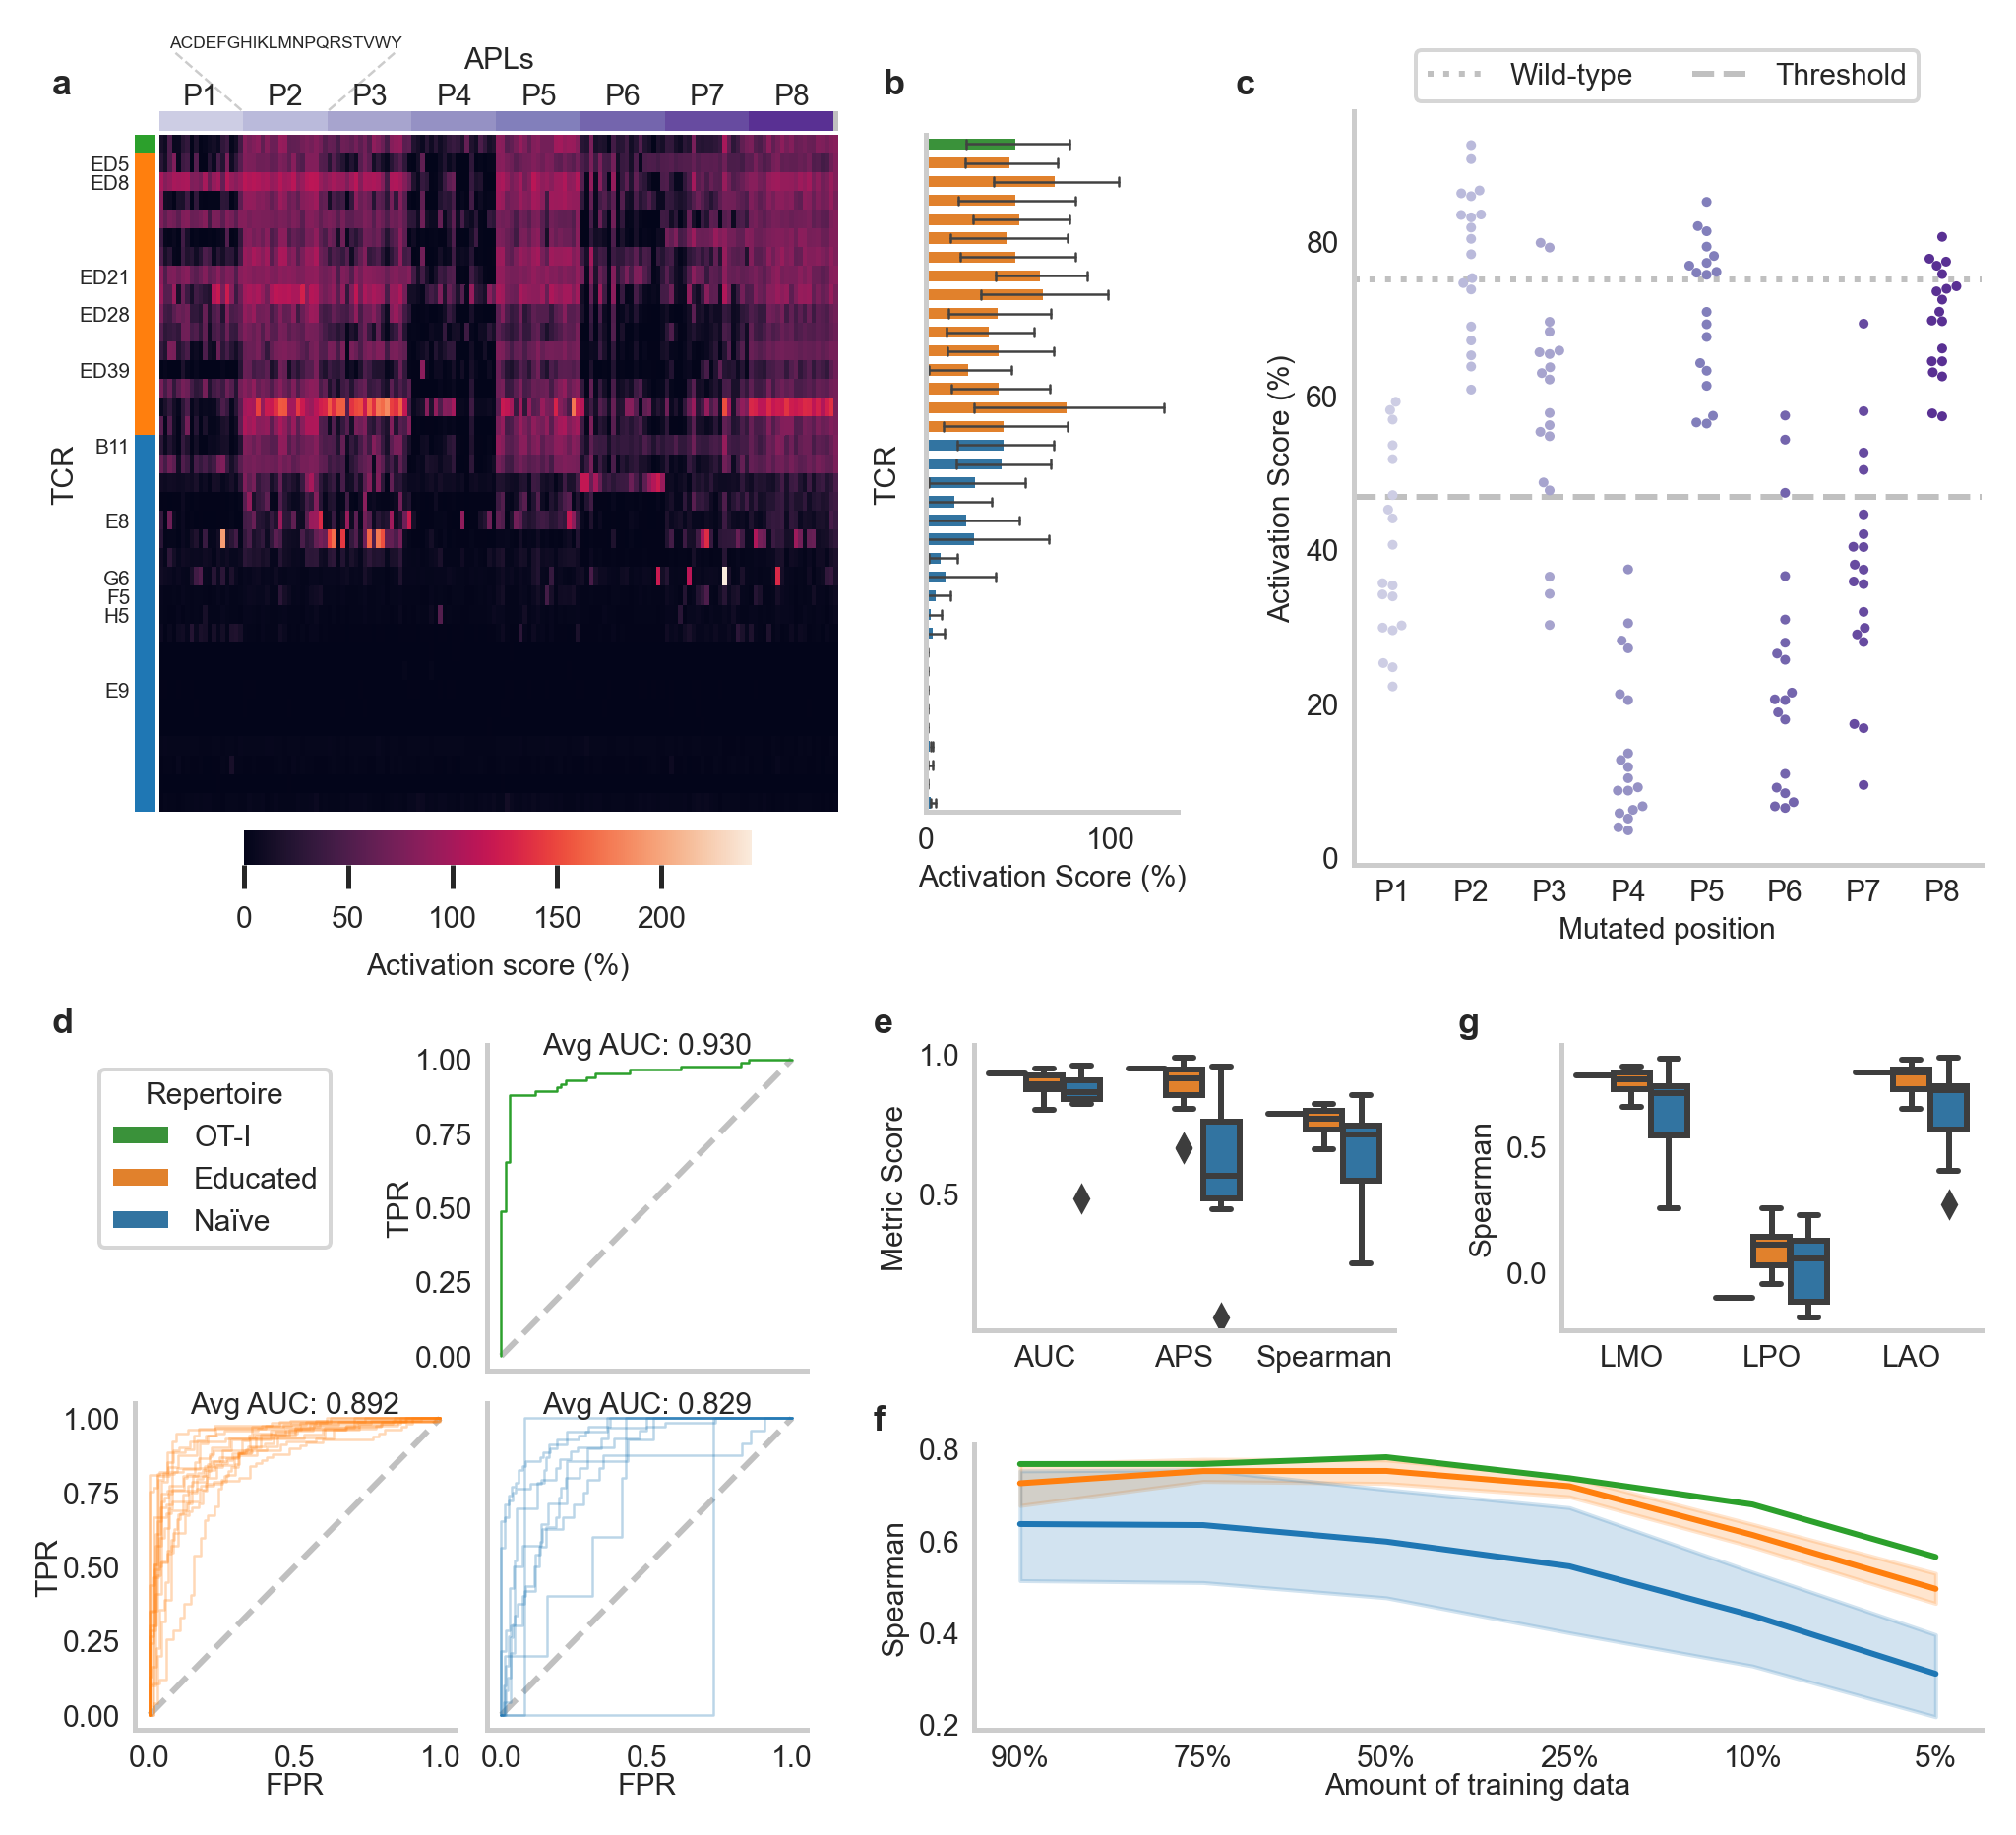

In [21]:
fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH * 0.9), dpi=DPI)
gridspecs = {}
axes = {}

gridspecs['gs_1-7'] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=2,
    ncols=1,
    height_ratios=[1.1, 1],
    width_ratios=[1],
    #wspace=0.1,
    hspace=0.25,
)

gridspecs['gs_123'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_1-7'][0],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[2, 3],
    wspace=0.1,
    #hspace=0.25,
)

gridspecs['gs_23'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_123'][1],
    nrows=1,
    ncols=2,
    height_ratios=[1, ],
    width_ratios=[2, 5],
    wspace=0.4,
    #hspace=0.25,
)

# Data
axes['ax_c'] = fig.add_subplot(gridspecs['gs_23'][1])
plot_activation_heatmap(data_mice_norm, gridspecs['gs_123'][0], fig)
axes['ax_b'] = plot_tcrs_averaged(data_mice_norm, gridspecs['gs_23'][0], fig=fig)
plot_epitopes(data_mice_norm, axes['ax_c'], do_legend=True)

# Within Performance
gridspecs['gs_4-7'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_1-7'][1],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[2, 3],
    wspace=0.2
)

gridspecs['gs_4'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs["gs_4-7"][0],
    nrows=2,
    ncols=2,
    height_ratios=[1, 1],
    width_ratios=[1, 1],
    wspace=0.1,
    hspace=0.1
)

gridspecs['gs_5-7'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_4-7'][1],
    nrows=2,
    ncols=1,
    height_ratios=[1, 1],
    width_ratios=[1],
    hspace=0.4,
)

gridspecs['gs_5-6'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_5-7'][0],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[1, 1],
    wspace=0.4
)

for i in range(4):
    axes[f'ax_4_{i}'] = fig.add_subplot(gridspecs['gs_4'][i])
axes['ax_5'] = fig.add_subplot(gridspecs['gs_5-6'][0])
axes['ax_6'] = fig.add_subplot(gridspecs['gs_5-6'][1])
axes['ax_7'] = fig.add_subplot(gridspecs['gs_5-7'][1])

plot_tcr_legend([axes['ax_b']], axes['ax_4_0'])
axes['ax_4_0'].axis('off')

plot_auc(ppdf[ppdf['Repertoire']=='OTI'], axes['ax_4_1'], ylabel='TPR')
plot_auc(ppdf[ppdf['Repertoire']=='Educated'], axes['ax_4_2'], ylabel='TPR', xlabel='FPR')
plot_auc(ppdf[ppdf['Repertoire']=='Naive'], axes['ax_4_3'], xlabel='FPR')


plot_metric_boxplot(['Spearman', 'AUC', 'APS'], axes['ax_5'])
plot_feature_tests(axes['ax_6'])
plot_data_size(axes['ax_7'])


fig.text(0.09, 0.888, 'a', size='large', weight='bold')
fig.text(0.439, 0.888, 'b', size='large', weight='bold')
fig.text(0.587, 0.888, 'c', size='large', weight='bold')

fig.text(0.09, 0.45, 'd', size='large', weight='bold')
fig.text(0.435, 0.45, 'e', size='large', weight='bold')
fig.text(0.68, 0.45, 'g', size='large', weight='bold')
fig.text(0.435, 0.265, 'f', size='large', weight='bold')

fig.text(0.1395, 0.91, 'ACDEFGHIKLMNPQRSTVWY', size='xx-small')
line_left = mpl.lines.Line2D([0.142, 0.17], [0.907, 0.88], linestyle='dashed', linewidth=0.5, color='gray', alpha=0.4)
line_right = mpl.lines.Line2D([0.234, 0.206], [0.907, 0.88], linestyle='dashed', linewidth=0.5, color='gray', alpha=0.4)
fig.add_artist(line_left)
fig.add_artist(line_right)

fig.tight_layout()
fig.savefig('figures/manuscript_fig2_data.pdf', dpi=DPI, bbox_inches='tight')
fig.savefig('figures/manuscript_fig2_data.png', dpi=DPI, bbox_inches='tight')


## Sup. X

<ipython-input-15-96e20ce0e636>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Activation'] = np.mean(data.values, axis=1)
<ipython-input-22-4253cf803f88>:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


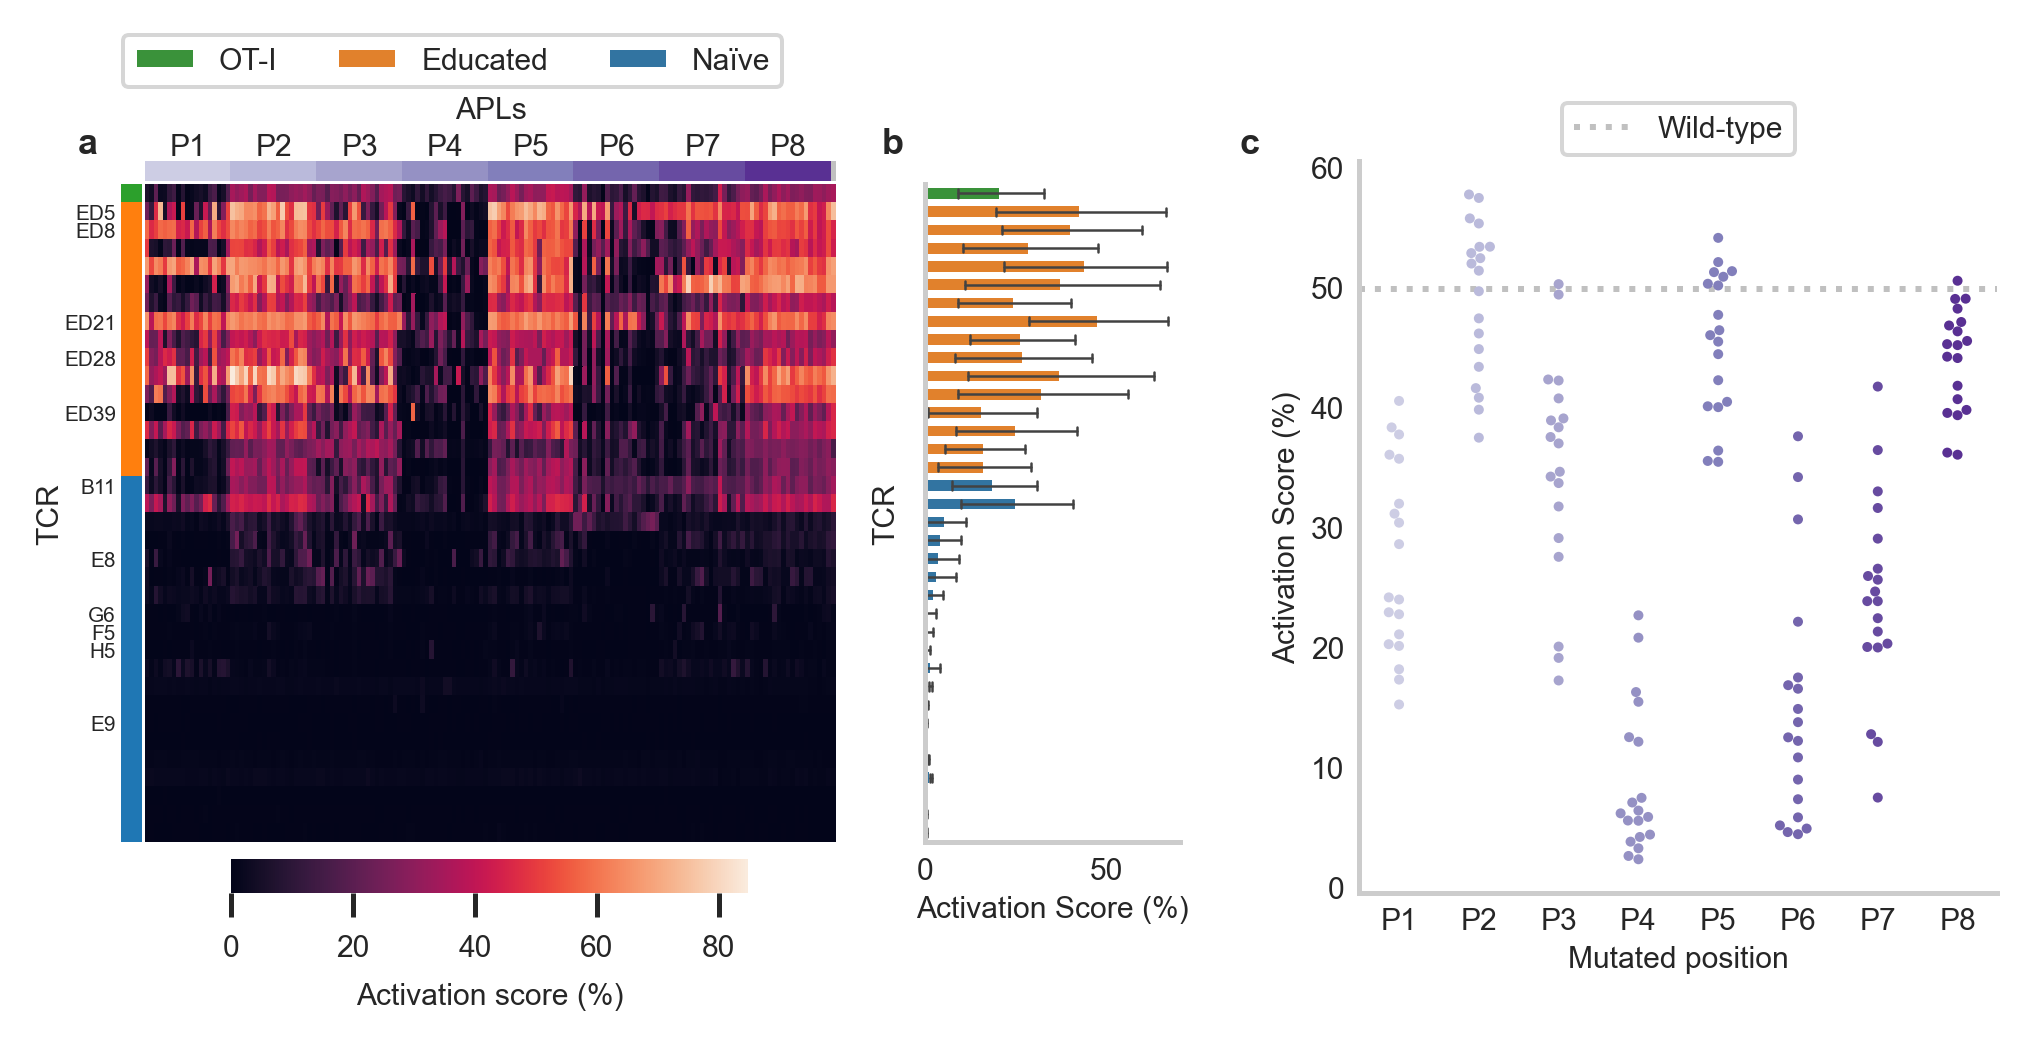

In [22]:
# a b 
# a c

# d e
# d f

fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH * 0.4), dpi=DPI)
gridspecs = {}
axes = {}

gridspecs['gs_123'] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[2, 3],
    wspace=0.1,
    #hspace=0.25,
)

gridspecs['gs_23'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_123'][1],
    nrows=1,
    ncols=2,
    height_ratios=[1, ],
    width_ratios=[2, 5],
    wspace=0.4,
    #hspace=0.25,
)

axes['ax_c'] = fig.add_subplot(gridspecs['gs_23'][1])
plot_activation_heatmap(data_mice_unnorm, gridspecs['gs_123'][0], fig)
axes['ax_b'] = plot_tcrs_averaged(data_mice_unnorm, gridspecs['gs_23'][0], fig=fig)
plot_epitopes(data_mice_unnorm, axes['ax_c'], threshold=None, do_legend=True)

plot_tcr_legend([axes['ax_b']], axes['ax_b'], style='top')

fig.text(0.107, 0.888, 'a', size='large', weight='bold')
fig.text(0.439, 0.888, 'b', size='large', weight='bold')
fig.text(0.587, 0.888, 'c', size='large', weight='bold')

fig.tight_layout()
fig.savefig('figures/manuscript_supp_unnormDataMice.pdf', dpi=DPI, bbox_inches='tight')
fig.savefig('figures/manuscript_supp_unnormDataMice.png', dpi=DPI, bbox_inches='tight')


## Sup. Y

<ipython-input-23-1bd938c879de>:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


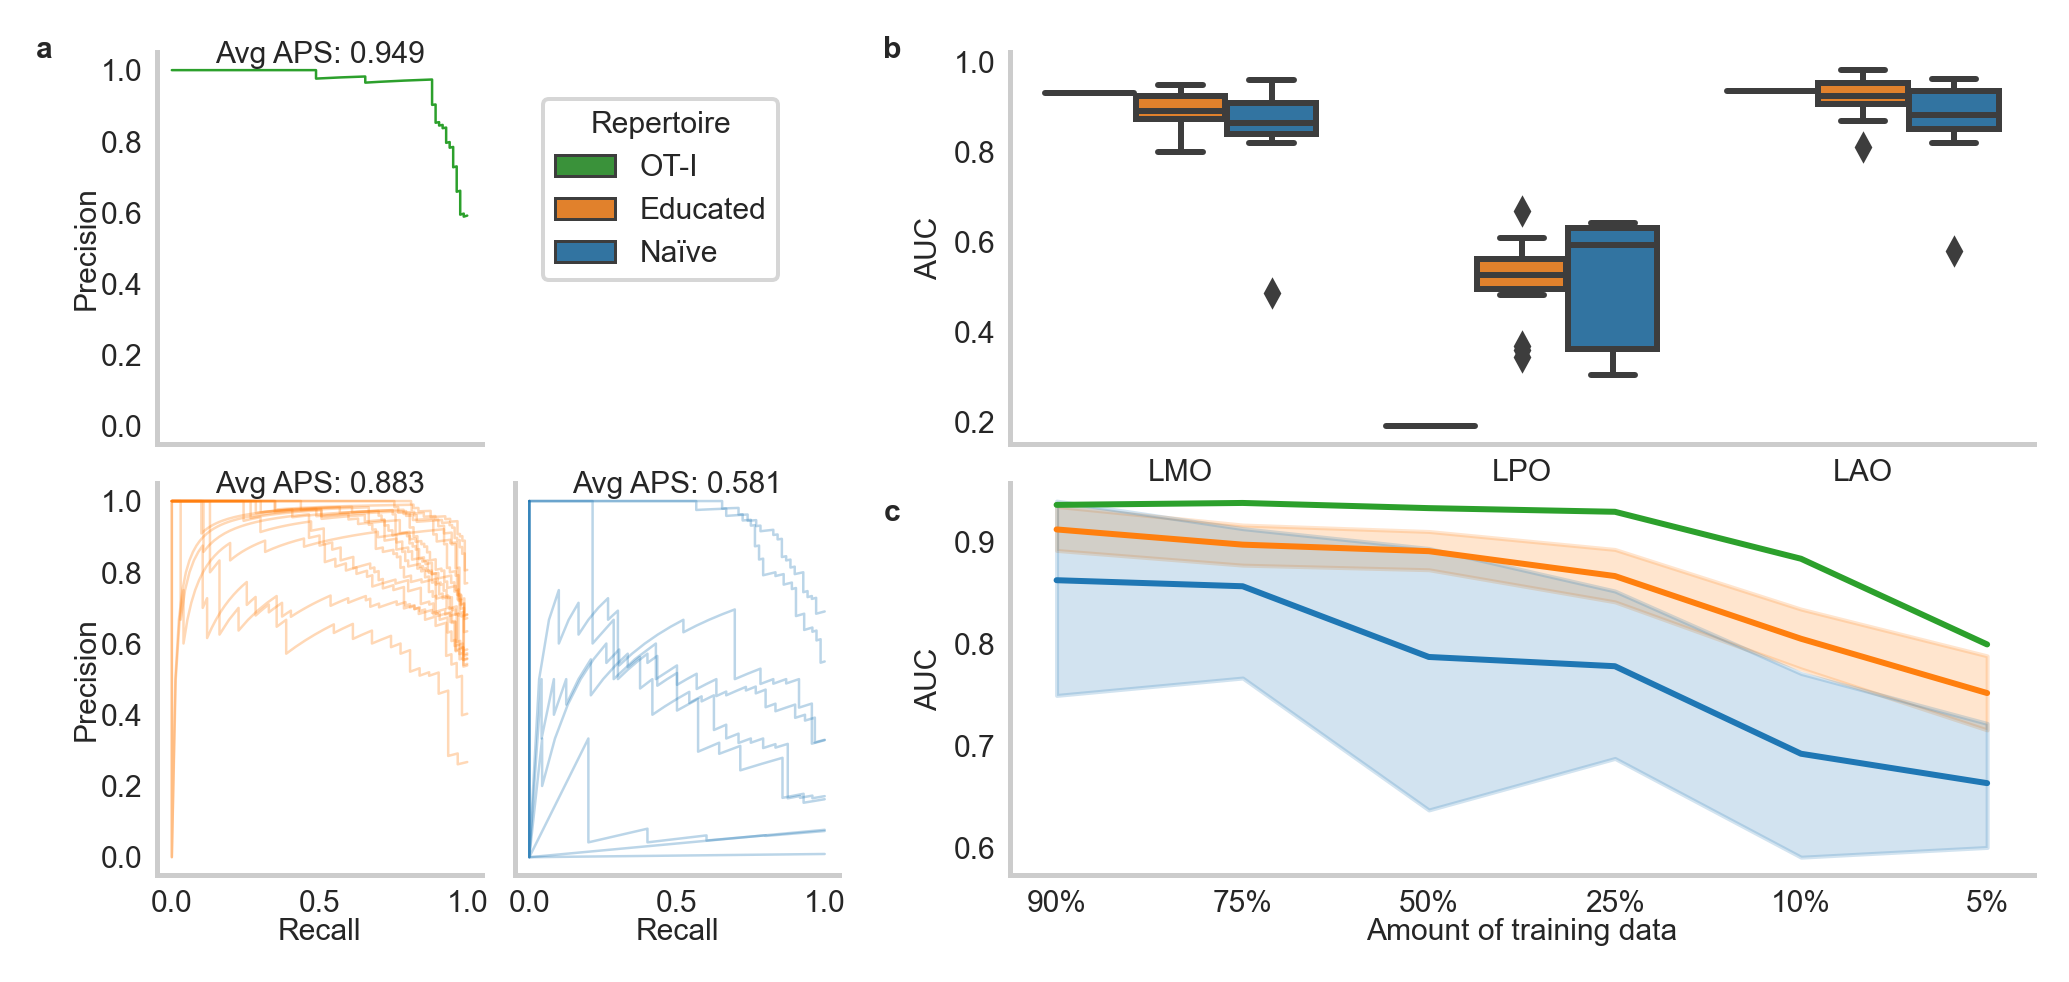

In [23]:
# a a c c 
# a a d d

fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH*0.45), dpi=DPI)

gridspecs = {}
axes = {}

gridspecs['gs_123'] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[2, 3],
    wspace=0.2
)

gridspecs['gs_1'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_123'][0],
    nrows=2,
    ncols=2,
    height_ratios=[1, 1],
    width_ratios=[1, 1],
    wspace=0.1,
    hspace=0.1
)

gridspecs['gs_23'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_123'][1],
    nrows=2,
    ncols=1,
    height_ratios=[1, 1],
    width_ratios=[1],
    hspace=0.1,
)

for i in range(4):
    axes[f'ax_1_{i}'] = fig.add_subplot(gridspecs['gs_1'][i])
axes['ax_2'] = fig.add_subplot(gridspecs['gs_23'][0])
axes['ax_3'] = fig.add_subplot(gridspecs['gs_23'][1])


plot_auc(ppdf[ppdf['Repertoire']=='OTI'], axes['ax_1_0'], ylabel='Precision',
         metric_func=metrics.precision_recall_curve, metric_name='APS')
plot_auc(ppdf[ppdf['Repertoire']=='Educated'], axes['ax_1_2'], ylabel='Precision',  xlabel='Recall',
         metric_func=metrics.precision_recall_curve, metric_name='APS')
plot_auc(ppdf[ppdf['Repertoire']=='Naive'], axes['ax_1_3'], xlabel='Recall', 
         metric_func=metrics.precision_recall_curve, metric_name='APS')


plot_feature_tests(axes['ax_2'], metric='AUC', do_legend=False)
plot_data_size(axes['ax_3'], metric='AUC')

plot_tcr_legend([axes['ax_2']], axes['ax_1_1'], style='center_right')
axes['ax_1_1'].axis('off')

fig.text(0.075, 0.875, 'a', weight='bold')
fig.text(0.425, 0.875, 'b', weight='bold')
fig.text(0.425, 0.45, 'c', weight='bold')

fig.tight_layout()
fig.savefig('figures/manuscript_supp_withinMetrics.pdf', dpi=DPI, bbox_inches='tight')
fig.savefig('figures/manuscript_supp_withinMetrics.png', dpi=DPI, bbox_inches='tight')

## Paper numbers - Data

In [24]:
(data_mice_norm > 46.9).sum()

OTI         85
Ed5         93
Ed8        118
Ed9         85
Ed10       103
Ed16-1      88
Ed16-30     78
Ed21       122
Ed23       104
Ed28        68
Ed31        57
Ed33        77
Ed39        32
Ed40        71
Ed45       101
Ed46        76
B11         70
B15         73
B3          23
F4          14
E8          24
B13         30
H6           0
G6           5
F5           1
H5           1
B2           0
B6           0
B5           0
E9           0
E4           0
G2           0
B16          0
B14          0
B7           0
B10          0
dtype: int64

In [25]:
((data_mice_norm > 46.9).sum()>=(152/2)).sum()

12

In [26]:
(data_mice_norm > 46.9).head(19)[['Ed5', 'Ed8']].sum()

Ed5     5
Ed8    19
dtype: int64

## Paper numbers - Within Prediction

## Statistical Tests

In [27]:
pd.set_option('display.expand_frame_repr', False)
print('---  summary statistics\n',
      lmdf.query('Split=="LMO"') \
          .groupby(['Metric', 'Repertoire'])['Value'].describe())

---  summary statistics
                            count       mean       std        min        25%        50%        75%        max
Metric         Repertoire                                                                                   
APS            Educated     15.0   0.882845  0.101530   0.661996   0.854451   0.911739   0.945910   0.987243
               Naive         7.0   0.581190  0.300983   0.062101   0.484155   0.565003   0.759270   0.954373
               OTI           1.0   0.949409       NaN   0.949409   0.949409   0.949409   0.949409   0.949409
AUC            Educated     15.0   0.892125  0.041760   0.799473   0.873060   0.890628   0.923946   0.948680
               Naive         7.0   0.829115  0.157914   0.485714   0.839554   0.864907   0.907423   0.959228
               OTI           1.0   0.929884       NaN   0.929884   0.929884   0.929884   0.929884   0.929884
MAE            Educated     15.0  13.741529  3.796440  10.494369  11.295885  11.994638  14.296917  23.8

In [28]:
lmdf.query('Metric=="Spearman"').groupby(['Metric', 'Repertoire', 'Split'])['Value'].mean()

Metric    Repertoire  Split
Spearman  Educated    L10O     0.724897
                      L25O     0.751424
                      L50O     0.751760
                      L75O     0.718414
                      L90O     0.612436
                      L95O     0.495145
                      LAO      0.774686
                      LMO      0.759604
                      LPO      0.090906
          Naive       L10O     0.636166
                      L25O     0.633871
                      L50O     0.598033
                      L75O     0.544270
                      L90O     0.437160
                      L95O     0.310421
                      LAO      0.639813
                      LMO      0.622688
                      LPO      0.017876
          OTI         L10O     0.766765
                      L25O     0.766933
                      L50O     0.781627
                      L75O     0.735870
                      L90O     0.678691
                      L95O     0.564652
            

In [29]:
lmdf.query('Metric=="AUC"').groupby(['Metric', 'Repertoire', 'Split'])['Value'].mean()

Metric  Repertoire  Split
AUC     Educated    L10O     0.912001
                    L25O     0.897109
                    L50O     0.890729
                    L75O     0.866333
                    L90O     0.804908
                    L95O     0.752147
                    LAO      0.920354
                    LMO      0.892125
                    LPO      0.511961
        Naive       L10O     0.902473
                    L25O     0.863856
                    L50O     0.787064
                    L75O     0.792406
                    L90O     0.714780
                    L95O     0.690503
                    LAO      0.890954
                    LMO      0.829115
                    LPO      0.499420
        OTI         L10O     0.936079
                    L25O     0.937959
                    L50O     0.932885
                    L75O     0.929309
                    L90O     0.883281
                    L95O     0.799347
                    LAO      0.935000
                    LMO 

In [30]:
print('---  worst three educated\n',
      lmdf.query('Split=="LMO"&Metric=="APS"&Repertoire=="Educated"') \
          .sort_values('Value').head(3))

---  worst three educated
         tcr Split  fold Metric     Value Repertoire
11138  ED39   LMO   NaN    APS  0.661996   Educated
11135  ED28   LMO   NaN    APS  0.667884   Educated
11136  ED31   LMO   NaN    APS  0.803862   Educated


In [31]:
print('---  best two educated\n')
print(lmdf.query('Split=="LMO"&Metric=="APS"&Repertoire=="Educated"') \
      .sort_values('Value').tail(2))
print()
print(lmdf.query('Split=="LMO"&Metric=="AUC"&Repertoire=="Educated"') \
          .sort_values('Value').tail(2))

---  best two educated

        tcr Split  fold Metric     Value Repertoire
11143   ED8   LMO   NaN    APS  0.980454   Educated
11133  ED21   LMO   NaN    APS  0.987243   Educated

          tcr Split  fold Metric     Value Repertoire
13356  ED16-1   LMO   NaN    AUC  0.943855   Educated
13358    ED21   LMO   NaN    AUC  0.948680   Educated


In [32]:
print('---  worst two naive\n',
      lmdf.query('Split=="LMO"&Metric=="APS"&Repertoire=="Naive"') \
          .sort_values('Value').head(2))

print('---  worst two naive\n',
      lmdf.query('Split=="LMO"&Metric=="AUC"&Repertoire=="Naive"') \
          .sort_values('Value').head(2))
print()
print('---  best naive\n',
      lmdf.query('Split=="LMO"&Metric=="AUC"&Repertoire=="Naive"') \
          .sort_values('Value').tail(5))

---  worst two naive
       tcr Split  fold Metric     Value Repertoire
11147  G6   LMO   NaN    APS  0.062101      Naive
11129  E8   LMO   NaN    APS  0.447293      Naive
---  worst two naive
       tcr Split  fold Metric     Value Repertoire
13372  G6   LMO   NaN    AUC  0.485714      Naive
13354  E8   LMO   NaN    AUC  0.820638      Naive

---  best naive
        tcr Split  fold Metric     Value Repertoire
13352  B15   LMO   NaN    AUC  0.895399      Naive
13353   B3   LMO   NaN    AUC  0.919447      Naive
13350  B11   LMO   NaN    AUC  0.959228      Naive
13371   F5   LMO   NaN    AUC       NaN      Naive
13373   H5   LMO   NaN    AUC       NaN      Naive


In [33]:
print('---  ot1 performance\n',
      lmdf.query('Split=="LMO"&Metric=="APS"&tcr=="OTI"'))

---  ot1 performance
        tcr Split  fold Metric     Value Repertoire
11149  OTI   LMO   NaN    APS  0.949409        OTI


In [34]:
print('---  spearman by position averaging spearman of individual tcrs\n',
      ppdf.query('features=="lpo"').groupby(['fold', 'tcr']).apply(
          lambda g: pd.Series(stats.spearmanr(g['act'], g['pred']), index=['rho', 'p'])
          ).reset_index().groupby('fold').mean().describe()
)

---  spearman by position averaging spearman of individual tcrs
             rho         p
count  8.000000  8.000000
mean   0.056830  0.429678
std    0.112388  0.045031
min   -0.144898  0.370256
25%   -0.001856  0.395992
50%    0.060226  0.429240
75%    0.143725  0.467887
max    0.196609  0.491170


In [35]:
print('---  spearman by amino acid averaging spearman of individual tcrs\n',
      ppdf.query('features=="lao"').groupby(['fold', 'tcr']).apply(
          lambda g: pd.Series(stats.spearmanr(g['act'], g['pred']), index=['rho', 'p'])
          ).reset_index().groupby('fold').mean().describe()
)

---  spearman by amino acid averaging spearman of individual tcrs
              rho          p
count  20.000000  20.000000
mean    0.726964   0.102291
std     0.095399   0.052324
min     0.483810   0.042243
25%     0.682407   0.054013
50%     0.737636   0.095733
75%     0.796616   0.130033
max     0.855238   0.216899


In [36]:
# t-test to find significance of split performance reduction
print('---  data size hypothesis testing')

for m in ['Spearman', 'AUC']:
    print(m)
    lmdf.query(f'Metric == "{m}"').groupby(['Split', 'tcr'])['Value'].mean().reset_index()

    for r in ['Naive', 'Educated']:
        print(f'---- {r}')
        lmo_aps = lmdf.query(f'Split=="LMO" & Metric == "{m}" & Repertoire =="{r}"').groupby('tcr')['Value'].mean().dropna()
        for split in lmdf['Split'].unique():
            if split == 'LMO':
                continue

            split_aps = lmdf.query(f'Split=="{split}" & Metric == "{m}" & Repertoire =="{r}"').groupby('tcr')['Value'].mean().dropna()
            assert np.all(lmo_aps.index == split_aps.index)
            tr = stats.wilcoxon(lmo_aps, split_aps, alternative='greater')
            md = split_aps.mean() - lmo_aps.mean()
            sd = np.sqrt((split_aps.var() + lmo_aps.var()) / 2)

            print(f'split {split} vs. LMO - mean difference {md:.4f} - effect size {md / sd:.4f} - W: {tr.statistic:.4f} , p: {tr.pvalue:.3e}')
    print(f'---- all')
    lmo_aps = lmdf.query(f'Split=="LMO" & Metric == "{m}" & Repertoire =="{r}"').groupby('tcr')['Value'].mean().dropna()
    for split in lmdf['Split'].unique():
        if split == 'LMO':
            continue

        split_aps = lmdf.query(f'Split=="{split}" & Metric == "{m}" & Repertoire =="{r}"').groupby('tcr')['Value'].mean().dropna()
        assert np.all(lmo_aps.index == split_aps.index)
        tr = stats.wilcoxon(lmo_aps, split_aps, alternative='greater')
        md = split_aps.mean() - lmo_aps.mean()
        sd = np.sqrt((split_aps.var() + lmo_aps.var()) / 2)

        print(f'split {split} vs. LMO - mean difference {md:.4f} - effect size {md / sd:.4f} - W: {tr.statistic:.4f} , p: {tr.pvalue:.3e}')
    print('')
    print('---')

---  data size hypothesis testing
Spearman
---- Naive
split L10O vs. LMO - mean difference 0.0135 - effect size 0.0656 - W: 15.0000 , p: 8.203e-01
split L25O vs. LMO - mean difference 0.0112 - effect size 0.0548 - W: 9.0000 , p: 9.512e-01
split L50O vs. LMO - mean difference -0.0247 - effect size -0.1203 - W: 39.0000 , p: 2.734e-02
split L75O vs. LMO - mean difference -0.0784 - effect size -0.3702 - W: 45.0000 , p: 1.953e-03
split L90O vs. LMO - mean difference -0.1855 - effect size -0.9638 - W: 45.0000 , p: 1.953e-03
split L95O vs. LMO - mean difference -0.3123 - effect size -1.7220 - W: 45.0000 , p: 1.953e-03
split LAO vs. LMO - mean difference 0.0171 - effect size 0.0853 - W: 9.0000 , p: 9.512e-01
split LPO vs. LMO - mean difference -0.6048 - effect size -3.3162 - W: 45.0000 , p: 1.953e-03
---- Educated
split L10O vs. LMO - mean difference -0.0347 - effect size -0.4843 - W: 92.0000 , p: 3.650e-02
split L25O vs. LMO - mean difference -0.0082 - effect size -0.1706 - W: 92.0000 , p: 3.

In [37]:
print('Spearman of LPO: \n',
    lmdf.query(f'Metric == "Spearman" & Split == "LPO"').groupby(['Repertoire'])['Value'].mean().reset_index())

print('\nAUC of LPO: \n',
    lmdf.query(f'Metric == "AUC" & Split == "LPO"').groupby(['Repertoire'])['Value'].mean().reset_index())

Spearman of LPO: 
   Repertoire     Value
0   Educated  0.090906
1      Naive  0.017876
2        OTI -0.103728

AUC of LPO: 
   Repertoire     Value
0   Educated  0.511961
1      Naive  0.499420
2        OTI  0.190924


In [38]:
print('Spearman of LPO: \n',
    lmdf.query(f'Metric == "Spearman" & Split == "LPO"')['Value'].mean())

print('\nAUC of LPO: \n',
    lmdf.query(f'Metric == "AUC" & Split == "LPO"')['Value'].mean())

Spearman of LPO: 
 0.05682950982311885

AUC of LPO: 
 0.495310489477568


## Metrics

In [39]:
lmdf

,tcr,Split,fold,Metric,Value,Repertoire
0,B11,LMO,NaN,R2,0.744313,Naive
1,B13,LMO,NaN,R2,0.231179,Naive
2,B15,LMO,NaN,R2,0.639624,Naive
3,B3,LMO,NaN,R2,0.473006,Naive
4,E8,LMO,NaN,R2,0.252263,Naive
...,...,...,...,...,...,...
15570,OTI,LPO,3.0,AUC,0.411765,OTI
15571,OTI,LPO,4.0,AUC,NaN,OTI
15572,OTI,LPO,5.0,AUC,0.000000,OTI
15573,OTI,LPO,6.0,AUC,0.542857,OTI


In [40]:
tmp = lmdf[(lmdf['Split']=='LMO') & (lmdf['Metric'].isin(['APS', 'AUC', 'Spearman']))
    ][['tcr', 'Metric', 'Value']].pivot(columns='Metric', index='tcr').sort_values('tcr').round(3)
tmp

Value                
Metric     APS    AUC Spearman
tcr                           
B11      0.954  0.959    0.854
B13      0.521  0.858    0.713
B15      0.917  0.895    0.780
B3       0.602  0.919    0.739
E8       0.447  0.821    0.665
ED10     0.930  0.905    0.755
ED16-1   0.946  0.944    0.802
ED16-30  0.941  0.920    0.801
ED21     0.987  0.949    0.709
ED23     0.949  0.891    0.661
ED28     0.668  0.799    0.735
ED31     0.804  0.873    0.793
ED33     0.908  0.928    0.708
ED39     0.662  0.873    0.768
ED40     0.829  0.850    0.822
ED45     0.912  0.841    0.777
ED46     0.880  0.890    0.822
ED5      0.946  0.907    0.746
ED8      0.980  0.938    0.724
ED9      0.900  0.875    0.772
F4       0.565  0.865    0.744
F5         NaN    NaN    0.547
G6       0.062  0.486    0.255
H5         NaN    NaN    0.307
OTI      0.949  0.930    0.786

In [41]:
tmp['Value']['AUC'].sort_values()

tcr
G6         0.486
ED28       0.799
E8         0.821
ED45       0.841
ED40       0.850
B13        0.858
F4         0.865
ED31       0.873
ED39       0.873
ED9        0.875
ED46       0.890
ED23       0.891
B15        0.895
ED10       0.905
ED5        0.907
B3         0.919
ED16-30    0.920
ED33       0.928
OTI        0.930
ED8        0.938
ED16-1     0.944
ED21       0.949
B11        0.959
F5           NaN
H5           NaN
Name: AUC, dtype: float64

Marked TCRs in Table

In [42]:
for metric in ['AUC', 'APS', 'Spearman']:
    print(metric)
    tmp = lmdf[(lmdf['Split']=='LMO') & (lmdf['Metric']==metric)
        ][['tcr', 'Metric', 'Value']].sort_values('Value').head(3)
    print(tmp)

AUC
        tcr Metric     Value
13372    G6    AUC  0.485714
13360  ED28    AUC  0.799473
13354    E8    AUC  0.820638
APS
       tcr Metric     Value
11147   G6    APS  0.062101
11129   E8    APS  0.447293
11126  B13    APS  0.521017
Spearman
     tcr    Metric     Value
4472  G6  Spearman  0.254830
4473  H5  Spearman  0.307406
4471  F5  Spearman  0.546866


In [43]:
for metric in ['AUC', 'APS', 'Spearman']:
    print(metric)
    tmp = lmdf[(lmdf['Split']=='LMO') & (lmdf['Metric']==metric) & (~lmdf['Value'].isna())
        ][['tcr', 'Metric', 'Value']].sort_values('Value').tail(3)
    print(tmp)

AUC
          tcr Metric     Value
13356  ED16-1    AUC  0.943855
13358    ED21    AUC  0.948680
13350     B11    AUC  0.959228
APS
        tcr Metric     Value
11125   B11    APS  0.954373
11143   ED8    APS  0.980454
11133  ED21    APS  0.987243
Spearman
       tcr    Metric     Value
4466  ED46  Spearman  0.821826
4464  ED40  Spearman  0.822245
4450   B11  Spearman  0.853862


## Regression metric, classification training

<ipython-input-44-84259700886b>:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


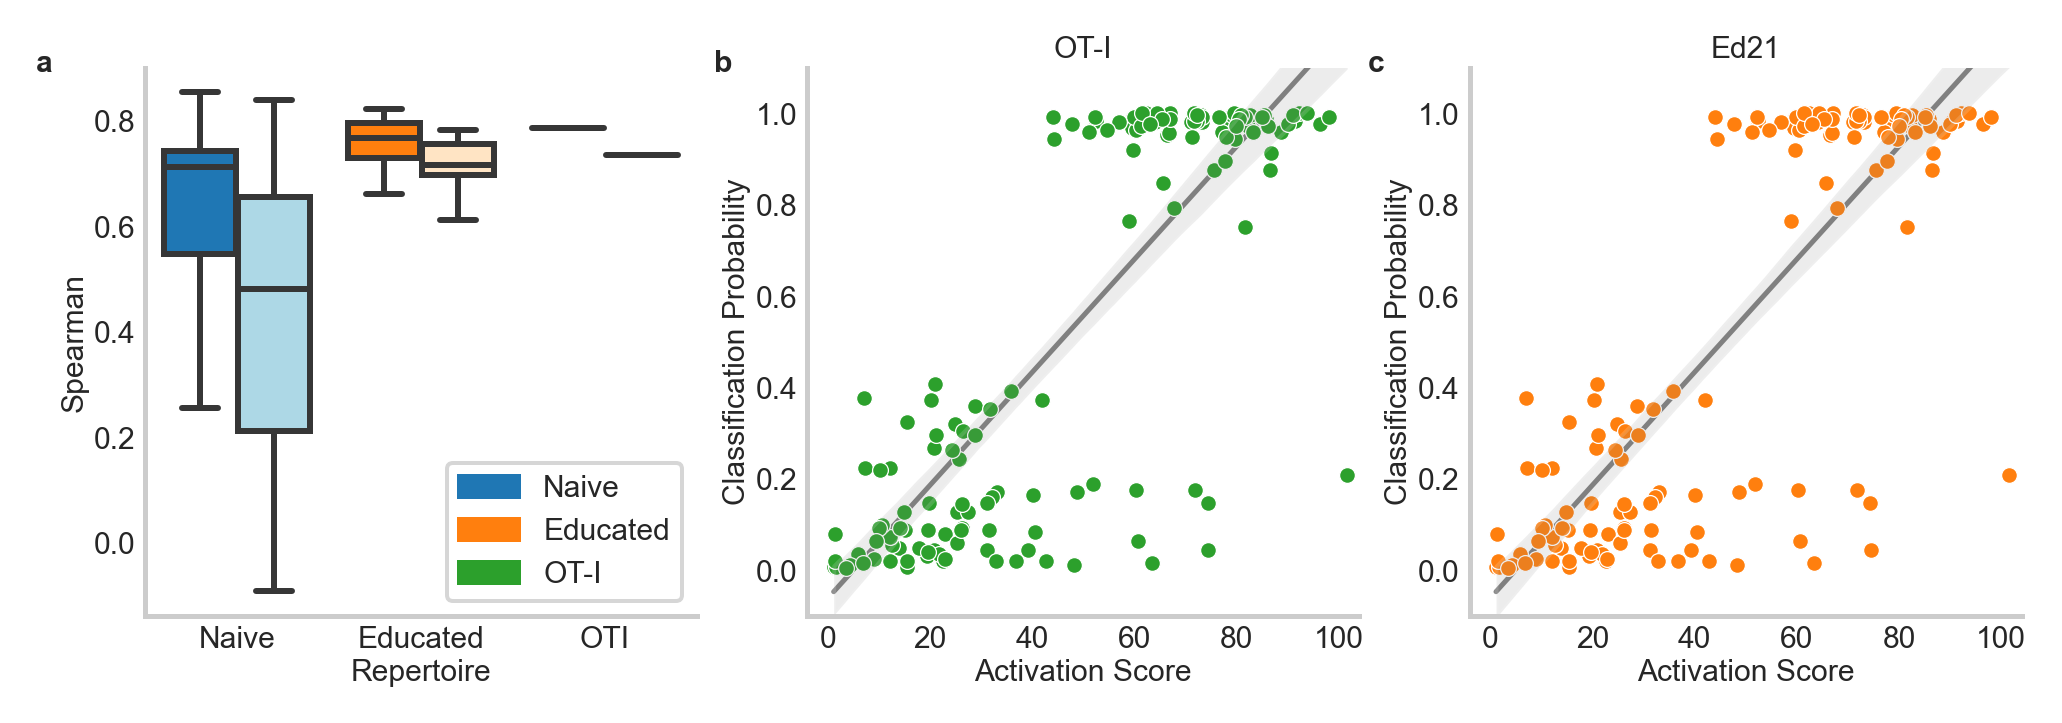

In [44]:
import matplotlib.patches as mpatches
df_plot = lmdf[lmdf['Metric'].str.contains('Spearman')
    & (lmdf['Split']=='LMO')]

fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH*0.30), dpi=DPI)
gridspecs = {}
axes = {}

gridspecs['gs_1-2'] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=3,
    height_ratios=[1],
    width_ratios=[1, 1, 1],
    #wspace=0.1,
    hspace=0.25,
)

ax_a = fig.add_subplot(gridspecs['gs_1-2'][0])
ax_b = fig.add_subplot(gridspecs['gs_1-2'][1])
ax_c = fig.add_subplot(gridspecs['gs_1-2'][2])

sb.boxplot(data=df_plot, x='Repertoire', y='Value', hue='Metric', ax=ax_a)
ax_a.grid(False)
sb.despine(ax=ax_a)
ax_a.set_ylabel('Spearman', labelpad=1)

ax_a.tick_params(axis='both', length=0, pad=2)
ax_a.set_xlabel('Repertoire', labelpad=1)

reps = ['Naive', 'Educated', 'OT-I']
colors_tmp = ['lightblue', 'bisque', 'palegreen']
for i, art in enumerate(ax_a.artists):
    c = palette_tcrs[reps[i//2]]
    art.set_facecolor(c)
    if i%2==1:
        #art.set_alpha(0.5)
        art.set_facecolor(colors_tmp[i//2])
legend_patches = [mpatches.Patch(color=palette_tcrs[name], label=name) for name in reps]
ax_a.legend(handles=legend_patches)


for tcr, ax in [('OT-I', ax_b), ('Ed21', ax_c)]:
    df_class_reg = ppdf[(ppdf['tcr']=='OTI') & (ppdf['features']=='lmo')]
    col = palette_tcrs['OT-I'] if tcr == 'OT-I' else palette_tcrs['Educated']
    sb.scatterplot(data=df_class_reg, x='act', y='pred_prob', color=col, ax=ax, s=10)
    sb.regplot(data=df_class_reg, y='pred_prob', x='act', color='gray', ax=ax, scatter=False, line_kws={'zorder': -1, 'linewidth':1})
    
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlim(-4, 104)
    ax.set_title(tcr, pad=2)
    
    ax.grid(False)
    ax.set_ylabel('Classification Probability', labelpad=1)
    ax.tick_params(axis='both', length=0, pad=2)
    ax.set_xlabel('Activation Score', labelpad=1)
    sb.despine(ax=ax)


fig.text(0.08, 0.875, 'a', weight='bold')
fig.text(0.36, 0.875, 'b', weight='bold')
fig.text(0.63, 0.875, 'c', weight='bold')

fig.tight_layout()
fig.savefig('figures/manuscript_supp_classReg.pdf', dpi=DPI, bbox_inches='tight')
fig.savefig('figures/manuscript_supp_classReg.png', dpi=DPI, bbox_inches='tight')

In [45]:
df_plot.groupby(['Metric', 'Repertoire'])['Value'].mean()

Metric          Repertoire
Spearman        Educated      0.759604
                Naive         0.622688
                OTI           0.786084
Spearman_class  Educated      0.715866
                Naive         0.439176
                OTI           0.735634
Name: Value, dtype: float64

## Positionwise Evaluation

In [46]:
def compute_class_score(g):
    return pd.Series({
        'Accuracy': (metrics.accuracy_score(g['is_activated'], g['pred_bin'])),
    })
ppdf['pred_bin'] = ppdf['pred_prob'] > 0.5

In [47]:
mdf = pd.concat([
    # except for lmo CV where each validation fold contained a single sample
    # in that case we just compute a global average for each tcr
    ppdf.query('features=="lmo"') \
        .groupby(['features', 'tcr', 'mut_pos']) \
        .apply(compute_metrics).reset_index(),
])
print(np.sum(mdf['AUC'].isna())/len(mdf))

0.405


C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [48]:
df_acc = ppdf.query('features=="lmo"') \
        .groupby(['features', 'tcr', 'mut_pos']) \
        .apply(compute_class_score).reset_index()
#acc = acc.rename(columns={0: 'Accuracy'})
df_acc['Repertoire'] = df_acc['tcr'].apply(assign_repertoire)
df_acc['mut_pos'] = df_acc['mut_pos'] + 1
df_acc.groupby('Repertoire')['Accuracy'].mean()

Repertoire
Educated    0.840351
Naive       0.903509
OTI         0.921053
Name: Accuracy, dtype: float64

<ipython-input-49-9809b41f72bd>:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


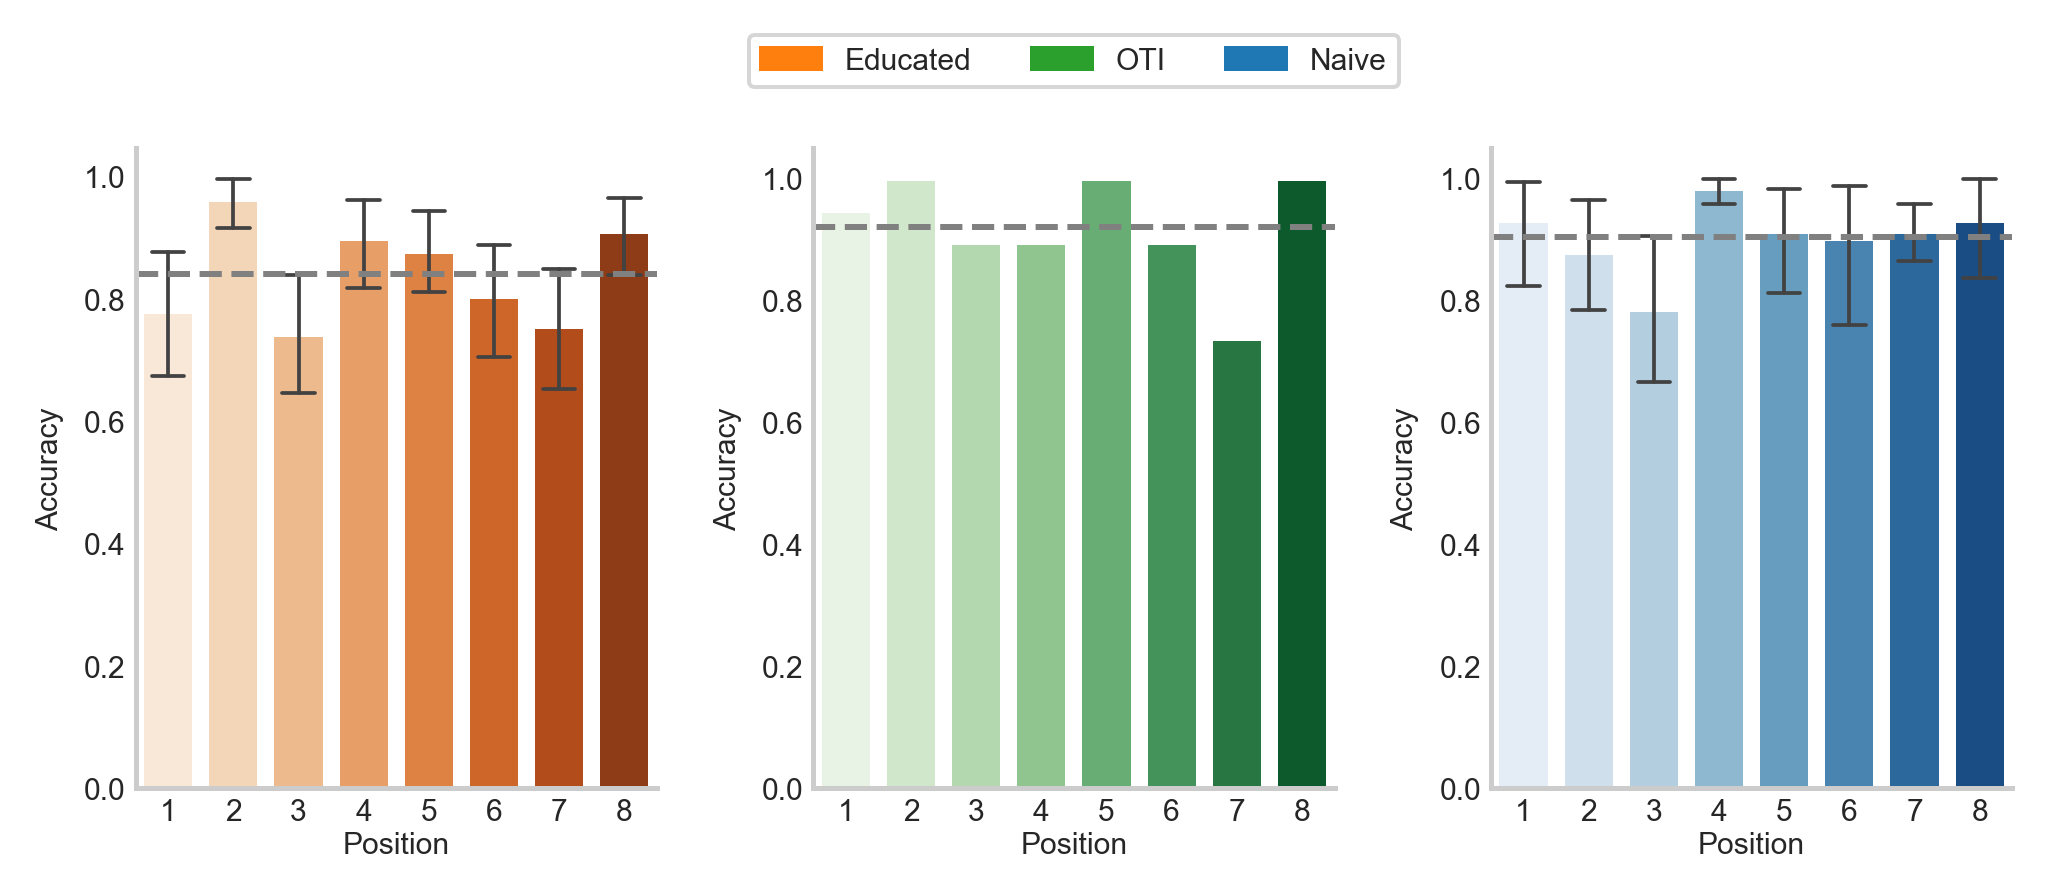

In [49]:
fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH*0.35), dpi=DPI)
gridspecs = {}
axes = {}

gridspecs['gs_1-3'] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=3,
    height_ratios=[1],
    width_ratios=[1, 1, 1],
    wspace=0.3,
    #hspace=0.4,
)


palette_cont = {
    'Educated': 'Oranges',
    'Naive': 'Blues',
    'OTI': 'Greens'
}
axes = []
for i, rep in enumerate(['Educated', 'OTI', 'Naive']):
    ax = fig.add_subplot(gridspecs['gs_1-3'][i])
    axes.append(ax)
    tmp = df_acc[df_acc['Repertoire']==rep]
    sb.barplot(data=tmp, y='Accuracy', x='mut_pos', ax=ax, palette=palette_cont[rep], errwidth=0.75, capsize=0.5)
    sb.despine(ax=ax)
    ax.axhline(tmp['Accuracy'].mean(), color='gray', linestyle='--')
    ax.grid(False)
    
    ax.tick_params(axis='both', length=0, pad=2)
    ax.set_xlabel('Position', labelpad=1)
    
legend_patches = [mpatches.Patch(color=palette_tcrs[name], label=name) for name in ['Educated', 'OTI', 'Naive']]
axes[1].legend(handles=legend_patches, ncol=3, loc='upper center', bbox_to_anchor=(0.5, 1.2))
    
fig.tight_layout()
fig.savefig('figures/manuscript_supp_poswiseAcc.pdf', dpi=DPI, bbox_inches='tight')
fig.savefig('figures/manuscript_supp_poswiseAcc.png', dpi=DPI, bbox_inches='tight')

In [50]:
mean_acc = df_acc['Accuracy'].mean()
print(mean_acc)
df_acc.groupby(['mut_pos'])['Accuracy'].mean()-mean_acc

0.8663157894736842


mut_pos
1   -0.026316
2    0.066316
3   -0.104211
4    0.062105
5    0.028421
6   -0.024211
7   -0.055789
8    0.053684
Name: Accuracy, dtype: float64

In [71]:
df_acc.groupby(['mut_pos'])['Accuracy'].mean()

mut_pos
1    0.840000
2    0.932632
3    0.762105
4    0.928421
5    0.894737
6    0.842105
7    0.810526
8    0.920000
Name: Accuracy, dtype: float64

In [51]:
df_acc.groupby(['Repertoire'])['Accuracy'].mean()

Repertoire
Educated    0.840351
Naive       0.903509
OTI         0.921053
Name: Accuracy, dtype: float64

In [52]:
df_acc.groupby(['Repertoire', 'mut_pos'])['Accuracy'].mean()

Repertoire  mut_pos
Educated    1          0.778947
            2          0.961404
            3          0.740351
            4          0.898246
            5          0.877193
            6          0.803509
            7          0.754386
            8          0.908772
Naive       1          0.929825
            2          0.877193
            3          0.783626
            4          0.982456
            5          0.912281
            6          0.900585
            7          0.912281
            8          0.929825
OTI         1          0.947368
            2          1.000000
            3          0.894737
            4          0.894737
            5          1.000000
            6          0.894737
            7          0.736842
            8          1.000000
Name: Accuracy, dtype: float64

In [69]:
def calculate_acc_majority():
    tmp = data_mice_norm > 46.9
    tmp = tmp[tmp.index != '0_0']
    tmp = tmp.sum()
    tmp = tmp[tmp>0]
    tmp = tmp/152
    tmp = tmp.apply(lambda x: x if x>0.5 else 1-x)
    return tmp.mean()
calculate_acc_majority()

0.6928947368421053

In [70]:
0.8663157894736842-0.6928947368421053

0.1734210526315788

## Positionwise Accuracy through distance matric

In [53]:
def index_2_epitope(ind):
    base_epitope = 'SIINFEKL'    
    pos = int(ind.split('_')[0])-1
    aminos = 'ACDEFGHIKLMNPQRSTVWY'.replace(base_epitope[pos], '')
    aa = int(ind.split('_')[1])
    aa = aminos[aa]
    epitope = base_epitope[:pos] + aa + base_epitope[pos+1:]
    return epitope
    
df_sim = data_mice_norm[data_mice_norm.index!='0_0'].copy()
df_sim.columns = [el.replace('Ed', 'ED') for el in df_sim.columns]
df_sim = df_sim[[el for el in df_sim.columns if el in df_acc['tcr'].values]]
df_sim['APL'] = df_sim.index.map(index_2_epitope)
df_sim['mut_pos'] = df_sim.index.str.split('_').str[0]
df_sim

,OTI,ED5,ED8,ED9,ED10,ED16-1,ED16-30,ED21,ED23,ED28,...,B15,B3,F4,E8,B13,G6,F5,H5,APL,mut_pos
1_0,15.425218,25.659542,101.391637,84.735907,78.110830,37.962250,48.661922,86.425899,93.415404,74.227278,...,64.234367,10.368266,1.111752,32.619332,26.326591,10.949465,4.555243,2.875408,AIINFEKL,1
1_1,8.974325,12.799865,81.356164,10.684505,60.697189,4.354701,14.320574,50.989813,53.433611,41.646603,...,43.769582,8.465832,1.038850,1.057994,1.957516,8.454650,2.588951,1.916939,CIINFEKL,1
1_2,48.749267,50.122836,88.844168,9.090369,75.041519,2.304598,25.965667,76.888236,54.367765,37.869133,...,68.076735,10.748753,0.772759,67.942051,3.555488,6.652839,2.523408,1.700510,DIINFEKL,1
1_3,5.924880,78.234689,101.594015,1.518225,71.032623,5.895813,4.126572,78.575669,93.602235,56.378734,...,57.551988,10.130461,1.184654,9.151719,3.555488,4.019424,2.883895,1.700510,EIINFEKL,1
1_4,6.893491,5.508727,98.659526,17.829649,58.066351,0.102505,1.926031,68.010873,15.282760,68.183327,...,10.934042,8.418271,1.421585,2.209021,0.731072,7.553745,2.294007,3.864796,FIINFEKL,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8_14,64.136513,51.079835,74.778861,65.378544,59.193853,74.369249,80.365445,65.883241,61.280505,39.766460,...,60.809648,13.459721,21.032165,7.781469,64.797769,1.448379,12.125468,2.813571,SIINFEKS,8
8_15,79.432149,53.532146,87.225140,79.327232,64.768724,76.490045,84.403594,66.103340,75.479646,58.740591,...,74.090876,32.816988,25.059989,16.155228,10.426768,5.959835,3.965356,4.359490,SIINFEKT,8
8_16,77.745131,43.543466,69.415830,69.648551,57.690517,65.603292,77.435545,57.959644,63.335644,53.725264,...,68.327324,37.192586,18.644632,17.212467,12.384284,9.424856,4.555243,3.215510,SIINFEKV,8
8_17,71.600834,46.653713,75.183619,72.969667,56.124542,65.461905,71.603141,61.994809,69.127399,48.380202,...,61.060237,21.687748,20.047991,12.512306,13.343067,32.293992,2.556180,1.545918,SIINFEKW,8


In [54]:
def aa_dif(base, apl):
    aa_ex = None
    for i, j in zip(base, apl):
        if i != j:
            return i, j
    raise ValueError
    
df_blosum = {
    'A': [ 4, -1, -2, -2,  0, -1, -1,  0, -2, -1, -1, -1, -1, -2, -1,  1,  0, -3, -2, 0],
    'R': [-1,  5,  0, -2, -3,  1,  0, -2,  0, -3, -2,  2, -1, -3, -2, -1, -1, -3, -2, -3],
    'N': [-2,  0,  6,  1, -3,  0,  0,  0,  1, -3, -3,  0, -2, -3, -2,  1,  0, -4, -2, -3],
    'D': [-2, -2,  1,  6, -3,  0,  2, -1, -1, -3, -4, -1, -3, -3, -1,  0, -1, -4, -3, -3],
    'C': [ 0, -3, -3, -3,  9, -3, -4, -3, -3, -1, -1, -3, -1, -2, -3, -1, -1, -2, -2, -1],
    'Q': [-1,  1,  0,  0, -3,  5,  2, -2,  0, -3, -2,  1,  0, -3, -1,  0, -1, -2, -1, -2],
    'E': [-1,  0,  0,  2, -4,  2,  5, -2,  0, -3, -3,  1, -2, -3, -1,  0, -1, -3, -2, -2],
    'G': [ 0, -2,  0, -1, -3, -2, -2,  6, -2, -4, -4, -2, -3, -3, -2,  0, -2, -2, -3, -3],
    'H': [-2,  0,  1, -1, -3,  0,  0, -2,  8, -3, -3, -1, -2, -1, -2, -1, -2, -2,  2, -3],
    'I': [-1, -3, -3, -3, -1, -3, -3, -4, -3,  4,  2, -3,  1,  0, -3, -2, -1, -3, -1, 3],
    'L': [-1, -2, -3, -4, -1, -2, -3, -4, -3,  2,  4, -2,  2,  0, -3, -2, -1, -2, -1, 1],
    'K': [-1,  2,  0, -1, -3,  1,  1, -2, -1, -3, -2,  5, -1, -3, -1,  0, -1, -3, -2, -2],
    'M': [-1, -1, -2, -3, -1,  0, -2, -3, -2,  1,  2, -1,  5,  0, -2, -1, -1, -1, -1, 1],
    'F': [-2, -3, -3, -3, -2, -3, -3, -3, -1,  0,  0, -3,  0,  6, -4, -2, -2,  1,  3, -1],
    'P': [-1, -2, -2, -1, -3, -1, -1, -2, -2, -3, -3, -1, -2, -4,  7, -1, -1, -4, -3, -2],
    'S': [ 1, -1,  1,  0, -1,  0,  0,  0, -1, -2, -2,  0, -1, -2, -1,  4,  1, -3, -2, -2],
    'T': [ 0, -1,  0, -1, -1, -1, -1, -2, -2, -1, -1, -1, -1, -2, -1,  1,  5, -2, -2, 0],
    'W': [-3, -3, -4, -4, -2, -2, -3, -2, -2, -3, -2, -3, -1,  1, -4, -3, -2, 11,  2, -3],
    'Y': [-2, -2, -2, -3, -2, -1, -2, -3,  2, -1, -1, -2, -1,  3, -3, -2, -2,  2,  7, -1],
    'V': [ 0, -3, -3, -3, -1, -2, -2, -3, -3,  3,  1, -2,  1, -1, -2, -2,  0, -3, -1, 4],
}
cols = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
df_blosum = pd.DataFrame(df_blosum, index=cols)

def blosum_dist(base, apl):
    old, new = aa_dif(base, apl)
    # high values => high similarity
    dist = df_blosum.loc[old, new]
    return dist

atchley_factors = {
    'A': [-0.591, -1.302, -0.733, 1.570, -0.146],
    'C': [-1.343, 0.465, -0.862, -1.020, -0.255],
    'D': [1.050, 0.302, -3.656, -0.259, -3.242],
    'E': [1.357, -1.453, 1.477, 0.113, -0.837],
    'F': [-1.006, -0.590, 1.891, -0.397, 0.412],
    'G': [-0.384, 1.652, 1.330, 1.045, 2.064],
    'H': [0.336, -0.417, -1.673, -1.474, -0.078],
    'I': [-1.239, -0.547, 2.131, 0.393, 0.816],
    'K': [1.831, -0.561, 0.533, -0.277, 1.648],
    'L': [-1.019, -0.987, -1.505, 1.266, -0.912],
    'M': [-0.663, -1.524, 2.219, -1.005, 1.212],
    'N': [0.945, 0.828, 1.299, -0.169, 0.933],
    'P': [0.189, 2.081, -1.628, 0.421, -1.392],
    'Q': [0.931, -0.179, -3.005, -0.503, -1.853],
    'R': [1.538, -0.055, 1.502, 0.440, 2.897],
    'S': [-0.228, 1.399, -4.760, 0.670, -2.647],
    'T': [-0.032, 0.326, 2.213, 0.908, 1.313],
    'V': [-1.337, -0.279, -0.544, 1.242, -1.262],
    'W': [-0.595, 0.009, 0.672, -2.128, -0.184],
    'Y': [0.260, 0.830, 3.097, -0.838, 1.512],
}

def atchley_dist(base, apl):
    old, new = aa_dif(base, apl)
    old = np.array(atchley_factors[old])
    new = np.array(atchley_factors[new])
    dist = np.linalg.norm(old-new)
    # max value = 9.04 => invert with 10 to change distance to similarity
    dist = 10 - dist
    return dist

df_sim['Blosum'] = df_sim['APL'].apply(lambda x: blosum_dist('SIINFEKL', x))
df_sim['Atchley'] = df_sim['APL'].apply(lambda x: atchley_dist('SIINFEKL', x))
df_sim

,OTI,ED5,ED8,ED9,ED10,ED16-1,ED16-30,ED21,ED23,ED28,...,F4,E8,B13,G6,F5,H5,APL,mut_pos,Blosum,Atchley
1_0,15.425218,25.659542,101.391637,84.735907,78.110830,37.962250,48.661922,86.425899,93.415404,74.227278,...,1.111752,32.619332,26.326591,10.949465,4.555243,2.875408,AIINFEKL,1,1,4.458439
1_1,8.974325,12.799865,81.356164,10.684505,60.697189,4.354701,14.320574,50.989813,53.433611,41.646603,...,1.038850,1.057994,1.957516,8.454650,2.588951,1.916939,CIINFEKL,1,-1,4.912000
1_2,48.749267,50.122836,88.844168,9.090369,75.041519,2.304598,25.965667,76.888236,54.367765,37.869133,...,0.772759,67.942051,3.555488,6.652839,2.523408,1.700510,DIINFEKL,1,0,7.703791
1_3,5.924880,78.234689,101.594015,1.518225,71.032623,5.895813,4.126572,78.575669,93.602235,56.378734,...,1.184654,9.151719,3.555488,4.019424,2.883895,1.700510,EIINFEKL,1,0,2.710786
1_4,6.893491,5.508727,98.659526,17.829649,58.066351,0.102505,1.926031,68.010873,15.282760,68.183327,...,1.421585,2.209021,0.731072,7.553745,2.294007,3.864796,FIINFEKL,1,-2,2.299794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8_14,64.136513,51.079835,74.778861,65.378544,59.193853,74.369249,80.365445,65.883241,61.280505,39.766460,...,21.032165,7.781469,64.797769,1.448379,12.125468,2.813571,SIINFEKS,8,-2,5.496763
8_15,79.432149,53.532146,87.225140,79.327232,64.768724,76.490045,84.403594,66.103340,75.479646,58.740591,...,25.059989,16.155228,10.426768,5.959835,3.965356,4.359490,SIINFEKT,8,-1,5.352371
8_16,77.745131,43.543466,69.415830,69.648551,57.690517,65.603292,77.435545,57.959644,63.335644,53.725264,...,18.644632,17.212467,12.384284,9.424856,4.555243,3.215510,SIINFEKV,8,1,8.715872
8_17,71.600834,46.653713,75.183619,72.969667,56.124542,65.461905,71.603141,61.994809,69.127399,48.380202,...,20.047991,12.512306,13.343067,32.293992,2.556180,1.545918,SIINFEKW,8,-2,5.762036


In [55]:
tcrs = [el for el in df_sim.columns if el not in ['APL', 'Blosum', 'Atchley', 'mut_pos']]
tcrs = [el for el in tcrs if el.startswith('Ed')]

content = {
    'tcr': [],
    'Repertoire': [],
    'mut_pos': [],
    'Metric': [],
    'Accuracy': [],
}


#for rep in ['Educated', 'Naive', 'OTI']:
tcrs = [el for el in df_sim.columns if el not in ['APL', 'Blosum', 'Atchley', 'mut_pos']]
#tcrs = [el for el in tcrs if assign_repertoire(el) == rep]
for distance in ['Blosum', 'Atchley']:
    for pos in range(1, 9):
        tmp_pos = df_sim[df_sim['mut_pos']==str(pos)].copy()

        thresholds = [-20] + tmp_pos[distance].unique().tolist()
        tmp_pos[tcrs] = tmp_pos[tcrs] > 46.9

        max_t = -20
        max_acc = -99
        for t in thresholds:
            tmp_pos_pred = tmp_pos[distance]>t
            #print(t)
            #print(tmp_pos_pred)
            acc = np.sum((tmp_pos[tcrs].values == tmp_pos_pred.values[:, np.newaxis])) / (len(tmp_pos) * len(tcrs))
            #print(acc)
            if acc > max_acc:
                max_acc = acc
                max_t = t

        for tcr in tcrs:
            content['tcr'].append(tcr)
            content['Repertoire'].append(assign_repertoire(tcr))
            content['mut_pos'].append(pos)
            content['Metric'].append(distance)

            tmp = df_sim[df_sim['mut_pos']==str(pos)][[tcr, distance]].copy()
            acc = np.sum((tmp[tcr]>46.9) == (tmp[distance]>max_t)) / len(tmp)
            content['Accuracy'].append(acc)

content = pd.DataFrame(content)
content.head(5)

,tcr,Repertoire,mut_pos,Metric,Accuracy
0,OTI,OTI,1,Blosum,0.947368
1,ED5,Educated,1,Blosum,0.736842
2,ED8,Educated,1,Blosum,0.000000
3,ED9,Educated,1,Blosum,0.894737
4,ED10,Educated,1,Blosum,0.052632


<ipython-input-56-25ab3b32c00e>:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


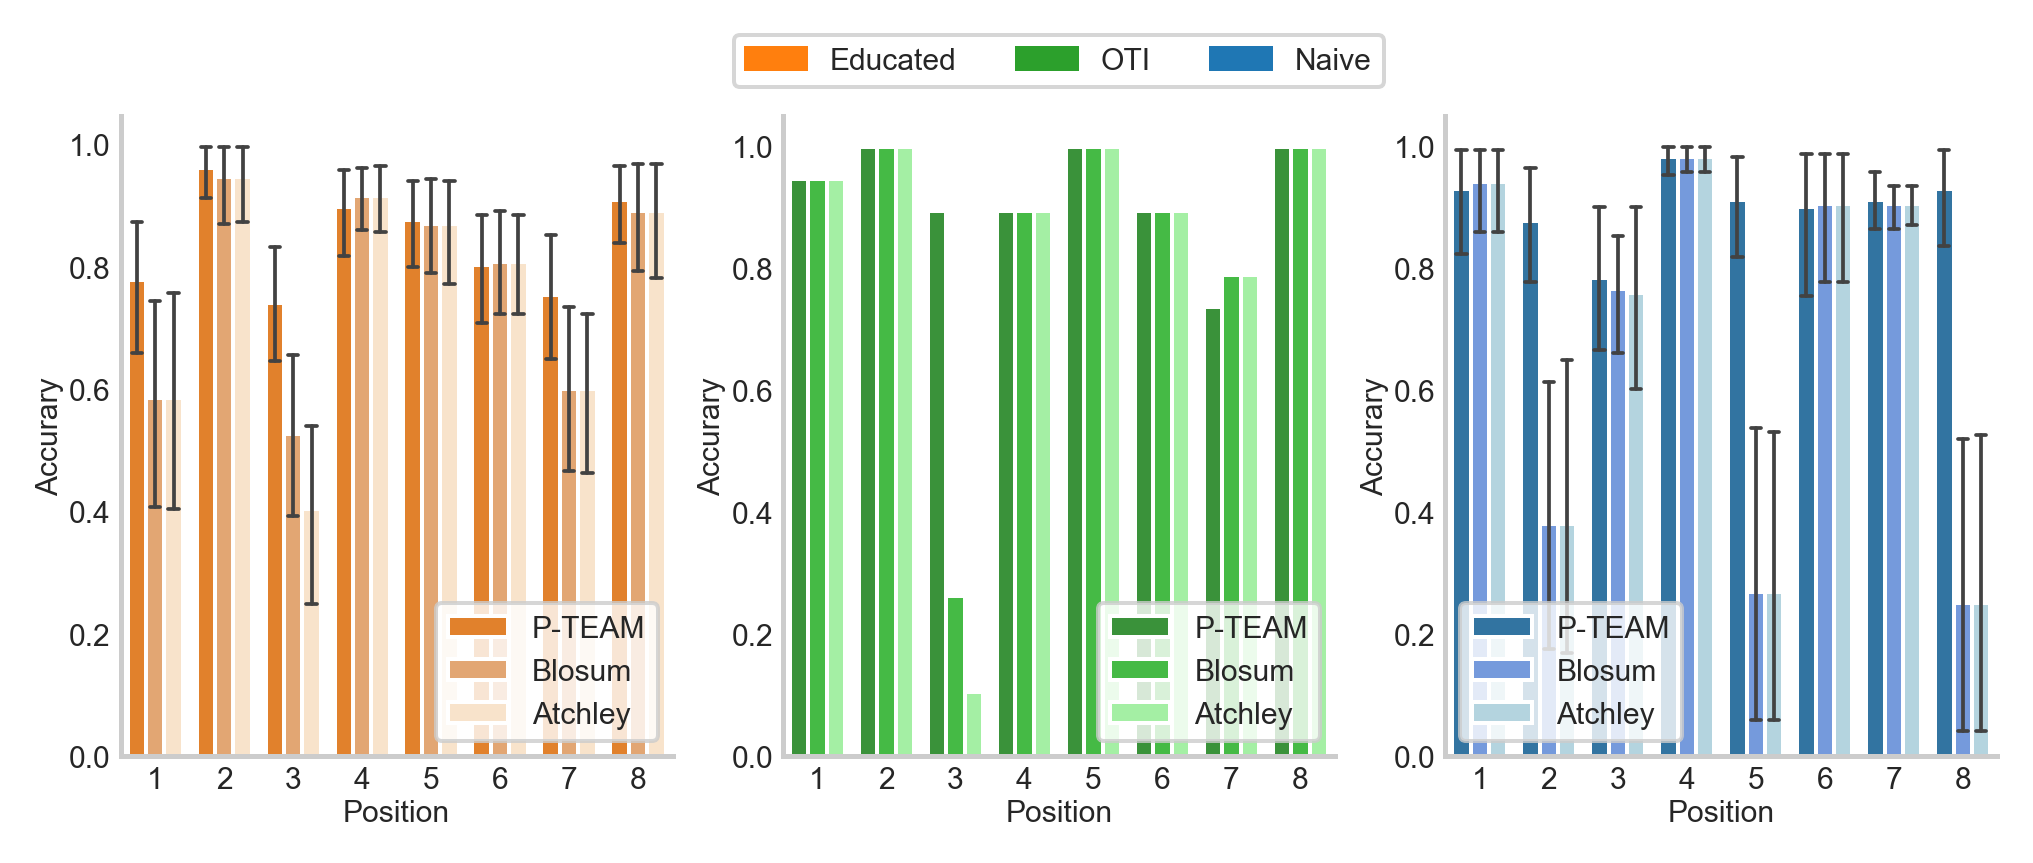

In [56]:
fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH*0.35), dpi=DPI)
gridspecs = {}
axes = {}

df_acc['Metric'] = 'P-TEAM'
df_dist_comp = pd.concat([df_acc#[df_acc['Repertoire']=='Educated']
                          , content])

gridspecs['gs_1-2'] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=3,
    height_ratios=[1],
    width_ratios=[1, 1, 1],
    wspace=0.2,
    #hspace=0.4,
)

palette_dists = {
    'Educated': ['tab:orange', 'sandybrown', 'bisque'],
    'Naive': ['tab:blue', 'cornflowerblue', 'lightblue'],
    'OTI': ['tab:green', 'limegreen', 'palegreen'],
}

axes = []
for i, rep in enumerate(['Educated', 'OTI', 'Naive']):
    ax = fig.add_subplot(gridspecs['gs_1-2'][i])
    axes.append(ax)
    pal = palette_dists[rep]
    sb.barplot(data=df_dist_comp[df_dist_comp['Repertoire']==rep], y='Accuracy', x='mut_pos', hue='Metric', ax=ax, 
               palette=pal, errwidth=0.75, capsize=0.15)
    sb.despine(ax=ax)
    ax.set_xlabel('Position')
    ax.grid(False)
    ax.set_ylabel('Accurary', labelpad=1)
    ax.tick_params(axis='both', length=0, pad=2)
    ax.set_xlabel('Position', labelpad=1)
    ax.legend(loc='lower right' if i != 2 else 'lower left')
    
ax2 = axes[1].twiny()
sb.despine(ax=ax2)
ax2.grid(False)
ax2.set_xticks([])
legend_patches = [mpatches.Patch(color=palette_tcrs[name], label=name) for name in ['Educated', 'OTI', 'Naive']]
ax2.legend(handles=legend_patches, ncol=3, loc='upper center', bbox_to_anchor=(0.5, 1.15))
    
fig.tight_layout()
fig.savefig('figures/manuscript_supp_poswiseAccVsDistance.pdf', dpi=DPI, bbox_inches='tight')
fig.savefig('figures/manuscript_supp_poswiseAccVsDistance.png', dpi=DPI, bbox_inches='tight')

In [57]:
df_dist_comp.groupby(['Metric'])['Accuracy'].mean()

Metric
Atchley    0.727632
Blosum     0.737895
P-TEAM     0.866316
Name: Accuracy, dtype: float64

In [58]:
0.866316-0.727632

0.13868400000000003

In [59]:
df_dist_comp.groupby(['Metric', 'mut_pos'])['Accuracy'].mean()

Metric   mut_pos
Atchley  1          0.728421
         2          0.745263
         3          0.520000
         4          0.938947
         5          0.658947
         6          0.846316
         7          0.717895
         8          0.665263
Blosum   1          0.728421
         2          0.745263
         3          0.602105
         4          0.938947
         5          0.658947
         6          0.846316
         7          0.717895
         8          0.665263
P-TEAM   1          0.840000
         2          0.932632
         3          0.762105
         4          0.928421
         5          0.894737
         6          0.842105
         7          0.810526
         8          0.920000
Name: Accuracy, dtype: float64

In [60]:
df_dist_comp.groupby(['Repertoire', 'Metric'])['Accuracy'].mean()

Repertoire  Metric 
Educated    Atchley    0.752632
            Blosum     0.767982
            P-TEAM     0.840351
Naive       Atchley    0.674708
            Blosum     0.675439
            P-TEAM     0.903509
OTI         Atchley    0.828947
            Blosum     0.848684
            P-TEAM     0.921053
Name: Accuracy, dtype: float64

In [61]:
0.840351-0.752632

0.08771899999999999